<a href="https://colab.research.google.com/github/Sophayie/Projet_IA_Tests_Algorythmes/blob/main/Tests_Algorythmes_Sophie_Mercier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 2 (IA 2) - Projet fin d'étape

Dans ce projet, il sera question de tester divers algorithmes d'apprentissage automatique (machine learning) sur différents jeux de données. Après les expérimentations, une analyse théorique comparera les résultats obtenus par chaque algorithme sur les différents jeux de données.

### **Sommaire**



1.   Présentation du projet et des jeux de données
2.   Importation des librairies et des jeux de données
3.   Nettoyage des données
4.   Adaptation de PlantVillage
5.   Définition des métriques
6.   Entrainement des algorithmes
7.   Visualisation des résultats
8.   Analyse des résultats



###**Présentation des différents jeux de données (datasets)**

Avant de débuter les importations des différents jeux de données, il est important de les présenter.

<u>MNIST:</u>

Le MNIST est une base de données de chiffres écrits à la main. C'est une base de données bien connue dans le domaine de l'IA puisqu'elle apporte un défi dans le fait qu'il est particulièrement difficile de faire de la reconnaissance de l'écriture manuscrite.

<u>Iris:</u>

Le jeu de données Iris comprend 50 échantillons de trois espèces d'Iris et dont quatre caractéristiques ont été utilisées pour les différencier. Dans ces caractéristiques on retrouve la longueur et la largeur des sépales et des pétales, en centimètres.

<u>PlantVillage dataset:</u>

PlantVillage est un jeu de données disponibles sur kaggle qui comprend 54 000 images de feuilles de plantes qui sont classées par espèce et type de maladie. On y retrouve les espèces de tomate, patate et poivron.
https://www.kaggle.com/datasets/emmarex/plantdisease



### **Importation des libraries**


**Installation de kagglehub pour l'importation du dataset PlantVillage et de memory_profiler pour la métrique de mémoire de Ram**

In [ ]:
!pip install kagglehub
!pip install memory_profiler

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import resample
from PIL import Image
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import hashlib
import psutil
import time
import warnings
from scipy.linalg import LinAlgWarning
from memory_profiler import memory_usage
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re
import json
import base64
from io import BytesIO
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.datasets import load_digits
from tqdm import tqdm

#Import pour les algorythmes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### **Importation des jeux de données (datasets)**

In [ ]:
#MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=True)

X_mnist = mnist.data
y_mnist = mnist.target.astype('int')

print("X_mnist shape:", X_mnist.shape)
print("y_mnist shape:", y_mnist.shape)

# Charger Iris
iris = load_iris(as_frame=True)

X_iris = iris.data
y_iris = iris.target

print("X_iris shape:", X_iris.shape)
print("y_iris shape:", y_iris.shape)
print("Classes:", iris.target_names)

#PlantVillage
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)


X_mnist shape: (70000, 784)
y_mnist shape: (70000,)
X_iris shape: (150, 4)
y_iris shape: (150,)
Classes: ['setosa' 'versicolor' 'virginica']
Path to dataset files: /kaggle/input/plantdisease


### **Nettoyage des données**
Avant de passer à la normalisation pour les trois jeux de données, il est important de prendre le temps de bien nettoyer les données du jeu choisi soit PlantVillage. Ce jeu étant basé sur des images en couleur, le nettoyage est différent que celui d'un jeu tabulaire comme MNIST. C'est dans cette optique que j'ai pris soin de bien choisir les fonctions qui me semblaient le plus pertinentes pour mon jeu choisi.

J'ai, donc,  choisi quatre fonctions de nettoyage soit la vérification des images corrompues ou illisibles, vérification et gestion des valeurs manquantes, mise à l'échelle des images et suppression des doublons.
<br> <br> <u>Vérification des images corrompues ou illisibles:</u>

PlantVillage est un jeu de données d'image et donc il est possible que lors du téléchargement certaines images aient été corrompues ou partiellement enregistrer. Elles peuvent aussi avoir été enregistrées sous un format inadéquat et donc illisible par certaines librairies. La corruption ainsi que le fait que ces images soient illisibles peuvent occasionner des problèmes tels que des erreurs durant l'entrainement, des arrêts inattendus des pipelines d'entraînement, une perte de temps et des erreurs dans les résultats.

<u>Mise à l’échelle des images:</u>

Les plages de valeurs des pixels des images du jeu de données de PlantVillage sont de 0 à 255. Pour certains algorithmes, comme SVM, ils sont sensibles aux échelles. Ce qui peut occasionner des problèmes tels que la domination des grandes valeurs sur les petites et le modèle peut converger difficilement et lentement.

Dans ce sens, en utilisant la mise à l'échelle, cela permet d'améliorer les performances et la convergence.

<u>Suppression des doublons:</u>

Dans un jeu de données qui contient des images, il y a toujours un risque pour qu'une image soit doublée. Les doublons peuvent biaiser l'entrainement, sembler offrir un gros volume de données alors que ce n'est pas le cas et aussi pousser le modèle à mémoriser plutôt que de généraliser.

Il est donc important de les retirer afin de rendre les évaluations plus juste, éviter le risque de surentrainement tout en accélérant celui-ci.

<u> Gestion du déséquilibre de classes (rééchantillonnage):</u>

On peut observer que PlantVillage a certaines classes qui sont davantage représentées que d'autres. Le modèle a tendance à prédire la classe majoritaire ce qui peut fausser les résultats.

Avec la gestion des classes, cela permet de rééquilibrer les classes et d'améliorer le rappel (recall) et le F-1 score.

**Vérification des images corrompues ou illisibles**

In [ ]:
root_dir = '/kaggle/input/plantdisease/PlantVillage'
corrupted_files = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Vérifie si l'image est corrompue
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {file_path}")
            corrupted_files.append(file_path)

print(f"Nombre d'images corrompues : {len(corrupted_files)}")


Corrupted image: /kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c
Nombre d'images corrompues : 1


**Mise à l'échelle**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # 0-1 scaling
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Nombre d'images chargées : {len(dataset)}")
print(f"Nombre de classes : {len(dataset.classes)}")
print(f"Classes : {dataset.classes}")

Nombre d'images chargées : 20638
Nombre de classes : 15
Classes : ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


**Suppression des doublons**

In [ ]:
hashes = {}
duplicate_files = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        with open(file_path, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
        if file_hash in hashes:
            duplicate_files.append(file_path)
        else:
            hashes[file_hash] = file_path

print(f"Nombre de doublons trouvés : {len(duplicate_files)}")

Nombre de doublons trouvés : 14


**Gestion du déséquilibre de classes (rééchantillonnage)**

In [ ]:
targets = [label for _, label in dataset]
class_counts = np.bincount(targets)
print("Nombre d'images par classe :", class_counts)

class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

balanced_loader = DataLoader(dataset, batch_size=32, sampler=sampler)


images, labels = next(iter(balanced_loader))
print("Taille d'un batch équilibré :", images.shape)
print("Labels du batch :", labels)

Nombre d'images par classe : [ 997 1478 1000 1000  152 2127 1000 1909  952 1771 1676 1404 3208  373
 1591]
Taille d'un batch équilibré : torch.Size([32, 3, 224, 224])
Labels du batch : tensor([ 3, 14,  1,  9, 11,  8,  5,  6, 11, 14, 12,  1,  4,  4,  5,  2,  9,  4,
         6, 10,  6, 14,  0,  2,  0, 14, 13,  1,  7,  1, 14, 12])


**Normalisation MNIST et IRIS**

In [ ]:
scaler = MinMaxScaler()

X_mnist_normalized = scaler.fit_transform(X_mnist)


X_iris_normalized = scaler.fit_transform(X_iris)


print("MNIST normalisé : min =", X_mnist_normalized.min(), ", max =", X_mnist_normalized.max())
print("IRIS normalisé : min =", X_iris_normalized.min(), ", max =", X_iris_normalized.max())

MNIST normalisé : min = 0.0 , max = 1.0
IRIS normalisé : min = 0.0 , max = 1.0


### **Adaptation de PlantVillage**

PlantVillage étant un jeu de données d'image, il n'est pas possible de tester les algorithmes demandés sans l'adapter. J'ai donc vectorisé les images et ensuite normalisé ceux-ci.

In [ ]:
# Transformations réduites
transform_flatten = transforms.Compose([
    transforms.Resize((32, 32)),  # réduit pour éviter d'exploser la RAM
    transforms.ToTensor()
])

dataset_plant = datasets.ImageFolder('/kaggle/input/plantdisease/PlantVillage', transform=transform_flatten)
loader_plant = DataLoader(dataset_plant, batch_size=64, shuffle=False)

X_plant_list = []
y_plant_list = []

for images, labels in loader_plant:
    # images: [batch_size, 3, 32, 32]
    batch_size = images.shape[0]
    images_flat = images.view(batch_size, -1)  # flatten
    X_plant_list.append(images_flat.numpy())
    y_plant_list.append(labels.numpy())

X_plant = np.concatenate(X_plant_list, axis=0)
y_plant = np.concatenate(y_plant_list, axis=0)

print("X_plant shape:", X_plant.shape)  # [n_samples, 32*32*3]
print("y_plant shape:", y_plant.shape)

X_plant shape: (20638, 3072)
y_plant shape: (20638,)


**Normalisation de PlantVillage**

In [ ]:
scaler = StandardScaler()
X_plant_norm = scaler.fit_transform(X_plant)


### **Définition des métriques**

Pour les métriques, j'ai appliqué les métriques vues en classe et deux métriques que je croyais intéressantes à ajouter pour l'exercice.

<u>Accuracy:</u>

L'accuracy permet de comparer plusieurs algorithmes (comme c'est le cas pour le projet) sur leur capacité à généraliser. Cette métrique est facile à comprendre et fournit une mesure globale de performance. Toutefois, sur des jeux de données qui ont des classes déséquilibrées, cette métrique peut montrer des limitations c'est pourquoi il est important de l'évaluer avec d'autres métriques.

<u>Précision:</u>

Cette métrique est particulièrement utile dans les jeux de données où les faux positifs sont coûteux comme c'est le cas pour PlantVillage. Dans ce jeu de données, un négatif peut déterminer à tort une maladie et entrainer des interventions non nécessaires pour la plante. La précision permet donc de mesurer la qualité des prédictions positives et donc permet de visualiser si le modèle est confiant dans ses prédictions.

<u>Recall:</u>

Cette métrique permet de mesure la capacité du modèle à détecter les vrais positifs. Ceci permet aussi de s'assurer que le modèle ne rate pas de cas important. C'est pratique aussi lorsque les faux négatifs sont coûteux comme c'est le cas pour le MNIST et le PlantVillage.

<u> F1-Score: </u>

Le F1-Score permet d'équilibrer la précision et le recall en les combinant dans un seul score. Ceci permet de mieux les comparer particulière lorsque les scores sont déséquilibrés. Ceci permet donc d'avoir une meilleure vision sur la performance globale du modèle en termes de qualité des prédictions.

<u> Matrice de confusion:</u>

Cette métrique est intéressante à ajouter pour son côté très visuel. Elle fournit une analyse détaillée des erreurs que le modèle a faite durant l'entrainement. Elle fournit un visuel des classes où le modèle s'est trompé. Ce qui permet aussi d'identifier les ajustements à faire sur le modèle.

<u> Temps d'exécution: </u>

Cette métrique a été ajoutée puisque je trouvais pertinent d'évaluer le temps d'entrainement. Certains algorithmes peuvent apporter de bons résultats, mais le temps d'exécution peut être très long et donc doit être pris en compte à la fin lors de l'analyse des résultats.

<u> Utilisation de la mémoire (ram): </u>

Dans un environnement comme Google Colab, la RAM est limitée et certains algorithmes utilisent beaucoup de mémoire. Cette métrique est pertinente, car encore une fois elle apporte une autre dimension aux résultats finals.

In [ ]:
def calculer_metriques(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

In [ ]:
def entrainement_et_mesure(clf, X_train, y_train):
    def entrainer():
        clf.fit(X_train, y_train)
        return clf
    mem_utilisee = memory_usage(entrainer, max_usage=True)
    return clf, round(max(mem_utilisee, 0), 2)

### **Entrainement des algorithmes**

Comme mentionné dans les métriques, certains algorithmes utilisent une grande quantité de RAMS. Malheureusement, les algorithmes de RBF SVM et Gaussian Process ne pouvaient tout simplement pas être exécutés sur des jeux de données aussi énormes que PlantVillage et MNIST. La raison est que ces algorithmes calculent et inversent une matrice de n*n (n = nombre d'échantillons). Dans le cas de Gaussian, il a une complexité de mémoire O(N²), car il doit construire, stocker et inverser cette matrice. Pour le RBF SVM, il a aussi une complexité de mémoire d’O.(N²), car il doit calculer et stocker la matrice de Gram entre chaque échantillon. C'est pour cette raison, que les deux jeux de données, PlantVillage ainsi que MNIST, ont des échantillons réduits pour ces deux algorithmes. Il est à noter que ces échantillons réduits sont spécifiés dans le code et le tableau de résultats et seront pris en compte durant l'analyse.

In [ ]:
# Liste des noms
names = [
    "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
    "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
    "Naive Bayes", "QDA"
]

# Liste des classificateurs correspondants
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [ ]:
# Créer le DataFrame de résultats
resultats = pd.DataFrame(columns=[
    "Dataset", "Algorithme", "Accuracy", "Precision", "Recall", "F1-score",
    "Memoire_MB", "Temps_s", "confusion_matrix"
])

# Liste des datasets préparés
datasets_list = [
    ("PlantVillage", X_plant_norm, y_plant),
    ("MNIST", X_mnist_normalized, y_mnist),
    ("IRIS", X_iris_normalized, y_iris)
]

# Préparer les filtres
names_filtered = [name for name in names if name not in ["RBF SVM", "Gaussian Process"]]
classifiers_filtered = [clf for name, clf in zip(names, classifiers) if name not in ["RBF SVM", "Gaussian Process"]]

# Séparer les algorithmes lents
names_slow_rbf = ["RBF SVM"]
classifiers_slow_rbf = [clf for name, clf in zip(names, classifiers) if name == "RBF SVM"]

names_slow_gp = ["Gaussian Process"]
classifiers_slow_gp = [clf for name, clf in zip(names, classifiers) if name == "Gaussian Process"]

names_fast = names_filtered
classifiers_fast = classifiers_filtered

# MNIST
X_mnist_rbf, y_mnist_rbf = resample(X_mnist_normalized, y_mnist, n_samples=3500, random_state=42)
X_mnist_gp, y_mnist_gp = resample(X_mnist_normalized, y_mnist, n_samples=700, random_state=42)

# PlantVillage
X_pv_rbf, y_pv_rbf = resample(X_plant_norm, y_plant, n_samples=int(0.05 * len(X_plant_norm)), random_state=42)
X_pv_gp, y_pv_gp = resample(X_plant_norm, y_plant, n_samples=int(0.01 * len(X_plant_norm)), random_state=42)

# Supprimer les LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)

# Boucle principale
for dataset_name, X, y in datasets_list:
    print(f"Traitement du dataset : {dataset_name}")
    from sklearn.model_selection import train_test_split

    if dataset_name == "MNIST":
        # --------- Algorithmes rapides sur MNIST complet ---------
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        for name, clf in zip(names_fast, classifiers_fast):
            print(f"Entraînement de l'algo (MNIST complet) : {name}")
            start_time = time.time()
            clf, mem_utilisee = entrainement_et_mesure(clf, X_train, y_train)
            y_pred = clf.predict(X_test)
            temps_execution = time.time() - start_time
            metriques = calculer_metriques(y_test, y_pred)
            nouvelle_ligne = pd.DataFrame([{
                "Dataset": dataset_name, "Algorithme": name,
                "Accuracy": metriques["accuracy"], "Precision": metriques["precision"],
                "Recall": metriques["recall"], "F1-score": metriques["f1_score"],
                "Memoire_MB": mem_utilisee, "Temps_s": temps_execution,
                "confusion_matrix": json.dumps(metriques["confusion_matrix"].tolist())
            }])
            resultats.loc[len(resultats)] = nouvelle_ligne.iloc[0]

        # --------- RBF SVM sur MNIST 5% ---------
        X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf = train_test_split(X_mnist_rbf, y_mnist_rbf, test_size=0.2, random_state=42)
        for name, clf in zip(names_slow_rbf, classifiers_slow_rbf):
            print(f"Entraînement de l'algo (MNIST 5%) : {name}")
            start_time = time.time()
            clf, mem_utilisee = entrainement_et_mesure(clf, X_train_rbf, y_train_rbf)
            y_pred = clf.predict(X_test_rbf)
            temps_execution = time.time() - start_time
            metriques = calculer_metriques(y_test_rbf, y_pred)
            nouvelle_ligne = pd.DataFrame([{
                "Dataset": dataset_name + " (Subset 5%)", "Algorithme": name,
                "Accuracy": metriques["accuracy"], "Precision": metriques["precision"],
                "Recall": metriques["recall"], "F1-score": metriques["f1_score"],
                "Memoire_MB": mem_utilisee, "Temps_s": temps_execution,
                "confusion_matrix": json.dumps(metriques["confusion_matrix"].tolist())
            }])
            resultats.loc[len(resultats)] = nouvelle_ligne.iloc[0]

        # --------- Gaussian Process sur MNIST 1% ---------
        X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(X_mnist_gp, y_mnist_gp, test_size=0.2, random_state=42)
        for name, clf in zip(names_slow_gp, classifiers_slow_gp):
            print(f"Entraînement de l'algo (MNIST 1%) : {name}")
            start_time = time.time()
            clf, mem_utilisee = entrainement_et_mesure(clf, X_train_gp, y_train_gp)
            y_pred = clf.predict(X_test_gp)
            temps_execution = time.time() - start_time
            metriques = calculer_metriques(y_test_gp, y_pred)
            nouvelle_ligne = pd.DataFrame([{
                "Dataset": dataset_name + " (Subset 1%)", "Algorithme": name,
                "Accuracy": metriques["accuracy"], "Precision": metriques["precision"],
                "Recall": metriques["recall"], "F1-score": metriques["f1_score"],
                "Memoire_MB": mem_utilisee, "Temps_s": temps_execution,
                "confusion_matrix": json.dumps(metriques["confusion_matrix"].tolist())
            }])
            resultats.loc[len(resultats)] = nouvelle_ligne.iloc[0]

    elif dataset_name == "PlantVillage":
        # --------- Algorithmes rapides sur PlantVillage complet ---------
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        for name, clf in zip(names_filtered, classifiers_filtered):
            print(f"Entraînement de l'algo : {name}")
            start_time = time.time()
            clf, mem_utilisee = entrainement_et_mesure(clf, X_train, y_train)
            y_pred = clf.predict(X_test)
            temps_execution = time.time() - start_time
            metriques = calculer_metriques(y_test, y_pred)
            nouvelle_ligne = pd.DataFrame([{
                "Dataset": dataset_name, "Algorithme": name,
                "Accuracy": metriques["accuracy"], "Precision": metriques["precision"],
                "Recall": metriques["recall"], "F1-score": metriques["f1_score"],
                "Memoire_MB": mem_utilisee, "Temps_s": temps_execution,
                "confusion_matrix": json.dumps(metriques["confusion_matrix"].tolist())
            }])
            resultats.loc[len(resultats)] = nouvelle_ligne.iloc[0]

        # --------- RBF SVM sur PlantVillage 5% ---------
        X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf = train_test_split(X_pv_rbf, y_pv_rbf, test_size=0.2, random_state=42)
        for name, clf in zip(names_slow_rbf, classifiers_slow_rbf):
            print(f"Entraînement de l'algo (PlantVillage 5%) : {name}")
            start_time = time.time()
            clf, mem_utilisee = entrainement_et_mesure(clf, X_train_rbf, y_train_rbf)
            y_pred = clf.predict(X_test_rbf)
            temps_execution = time.time() - start_time
            metriques = calculer_metriques(y_test_rbf, y_pred)
            nouvelle_ligne = pd.DataFrame([{
                "Dataset": dataset_name + " (Subset 5%)", "Algorithme": name,
                "Accuracy": metriques["accuracy"], "Precision": metriques["precision"],
                "Recall": metriques["recall"], "F1-score": metriques["f1_score"],
                "Memoire_MB": mem_utilisee, "Temps_s": temps_execution,
                "confusion_matrix": json.dumps(metriques["confusion_matrix"].tolist())
            }])
            resultats.loc[len(resultats)] = nouvelle_ligne.iloc[0]

        # --------- Gaussian Process sur PlantVillage 1% ---------
        X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(X_pv_gp, y_pv_gp, test_size=0.2, random_state=42)
        for name, clf in zip(names_slow_gp, classifiers_slow_gp):
            print(f"Entraînement de l'algo (PlantVillage 1%) : {name}")
            start_time = time.time()
            clf, mem_utilisee = entrainement_et_mesure(clf, X_train_gp, y_train_gp)
            y_pred = clf.predict(X_test_gp)
            temps_execution = time.time() - start_time
            metriques = calculer_metriques(y_test_gp, y_pred)
            nouvelle_ligne = pd.DataFrame([{
                "Dataset": dataset_name + " (Subset 1%)", "Algorithme": name,
                "Accuracy": metriques["accuracy"], "Precision": metriques["precision"],
                "Recall": metriques["recall"], "F1-score": metriques["f1_score"],
                "Memoire_MB": mem_utilisee, "Temps_s": temps_execution,
                "confusion_matrix": json.dumps(metriques["confusion_matrix"].tolist())
            }])
            resultats.loc[len(resultats)] = nouvelle_ligne.iloc[0]

    else:
        # --------- IRIS ---------
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        for name, clf in zip(names, classifiers):
            print(f" Entraînement de l'algo : {name}")
            start_time = time.time()
            clf, mem_utilisee = entrainement_et_mesure(clf, X_train, y_train)
            y_pred = clf.predict(X_test)
            temps_execution = time.time() - start_time
            metriques = calculer_metriques(y_test, y_pred)
            nouvelle_ligne = pd.DataFrame([{
                "Dataset": dataset_name, "Algorithme": name,
                "Accuracy": metriques["accuracy"], "Precision": metriques["precision"],
                "Recall": metriques["recall"], "F1-score": metriques["f1_score"],
                "Memoire_MB": mem_utilisee, "Temps_s": temps_execution,
                "confusion_matrix": json.dumps(metriques["confusion_matrix"].tolist())
            }])
            resultats.loc[len(resultats)] = nouvelle_ligne.iloc[0]

print("Tous les algorithmes ont été passés sur les 3 datasets.")

# Sauvegarde CSV
resultats.to_csv("resultats_comparaison_3_datasets.csv", index=False)
print("Résultats sauvegardés dans 'resultats_comparaison_3_datasets.csv'.")


Traitement du dataset : PlantVillage
Entraînement de l'algo : Nearest Neighbors
Entraînement de l'algo : Linear SVM
Entraînement de l'algo : Decision Tree
Entraînement de l'algo : Random Forest
Entraînement de l'algo : Neural Net
Entraînement de l'algo : AdaBoost
Entraînement de l'algo : Naive Bayes
Entraînement de l'algo : QDA
Entraînement de l'algo (PlantVillage 5%) : RBF SVM
Entraînement de l'algo (PlantVillage 1%) : Gaussian Process
Traitement du dataset : MNIST
Entraînement de l'algo (MNIST complet) : Nearest Neighbors
Entraînement de l'algo (MNIST complet) : Linear SVM
Entraînement de l'algo (MNIST complet) : Decision Tree
Entraînement de l'algo (MNIST complet) : Random Forest
Entraînement de l'algo (MNIST complet) : Neural Net
Entraînement de l'algo (MNIST complet) : AdaBoost
Entraînement de l'algo (MNIST complet) : Naive Bayes
Entraînement de l'algo (MNIST complet) : QDA
Entraînement de l'algo (MNIST 5%) : RBF SVM
Entraînement de l'algo (MNIST 1%) : Gaussian Process
Traitement 

**Affichage des résultats par tableau**

In [ ]:
style_css = """
<style>
.tabs {overflow: hidden;}
.tab {float: left; padding: 10px 20px; cursor: pointer; background: #1A231F; margin-right: 5px; border-radius: 5px;}
.tab:hover {background:#587468;}
.tab.active {background: #587468; border-bottom: 2px solid #587468;}
.tab-content {display: none; padding: 10px; background: #587468; border: 1px solid #1A231F;}
.tab-content.active {display: block;}

table.dataframe {border-collapse: collapse; width: 100%; color: #FBF5EE;}
table.dataframe th, table.dataframe td {border: 1px solid #1A231F; padding: 8px; text-align: center;}
table.dataframe th {background-color: #A1BAAF;}

table.dataframe caption {
    caption-side: top;
    font-size: 1.3em;
    font-weight: bold;
    padding: 8px;
    color: #FBF5EE;
}

table.dataframe tbody tr:hover {
    background-color: #A1BAAF !important;
    color: #1A231F !important;
    cursor: pointer;
}
table.dataframe tbody tr:nth-child(odd) {background-color: #2B3B34;}
</style>

<script>
function openTab(evt, tabName) {
    var i, tabcontent, tablinks;
    tabcontent = document.getElementsByClassName("tab-content");
    for (i = 0; i < tabcontent.length; i++) { tabcontent[i].style.display = "none"; }
    tablinks = document.getElementsByClassName("tab");
    for (i = 0; i < tablinks.length; i++) { tablinks[i].className = tablinks[i].className.replace(" active", ""); }
    document.getElementById(tabName).style.display = "block";
    evt.currentTarget.className += " active";
}
</script>
"""
df_pv = resultats[resultats["Dataset"].str.contains("PlantVillage", case=False)].reset_index(drop=True)
df_mnist = resultats[resultats["Dataset"].str.contains("MNIST", case=False)].reset_index(drop=True)
df_iris = resultats[resultats["Dataset"].str.contains("IRIS", case=False)].reset_index(drop=True)

html_pv = df_pv.drop(columns=["confusion_matrix"]).style.set_table_attributes('class="dataframe"').format(precision=3).set_caption("Résultats PlantVillage").to_html()
html_mnist = df_mnist.drop(columns=["confusion_matrix"]).style.set_table_attributes('class="dataframe"').format(precision=3).set_caption("Résultats MNIST").to_html()
html_iris = df_iris.drop(columns=["confusion_matrix"]).style.set_table_attributes('class="dataframe"').format(precision=3).set_caption("Résultats IRIS").to_html()


full_html = f"""
{style_css}
<div class="tabs">
    <div class="tab active" onclick="openTab(event, 'pv')">PlantVillage</div>
    <div class="tab" onclick="openTab(event, 'mnist')">MNIST</div>
    <div class="tab" onclick="openTab(event, 'iris')">IRIS</div>
</div>

<div id="pv" class="tab-content active">{html_pv}</div>
<div id="mnist" class="tab-content">{html_mnist}</div>
<div id="iris" class="tab-content">{html_iris}</div>
"""

display(HTML(full_html))


Des onglets sont disponibles pour visualiser les différents résultats des métriques selon les jeux de données.

**Visualisation des matrices de confusion - PlantVillage**

In [ ]:
noms_classes = [
    "Apple Scab", "Apple Black Rot", "Apple Cedar Rust", "Apple Healthy", "Blueberry Healthy",
    "Cherry Powdery Mildew", "Cherry Healthy", "Corn Cercospora", "Corn Common Rust",
    "Corn Northern Leaf Blight", "Corn Healthy", "Grape Black Rot", "Grape Esca", "Grape Leaf Blight",
    "Grape Healthy"
]


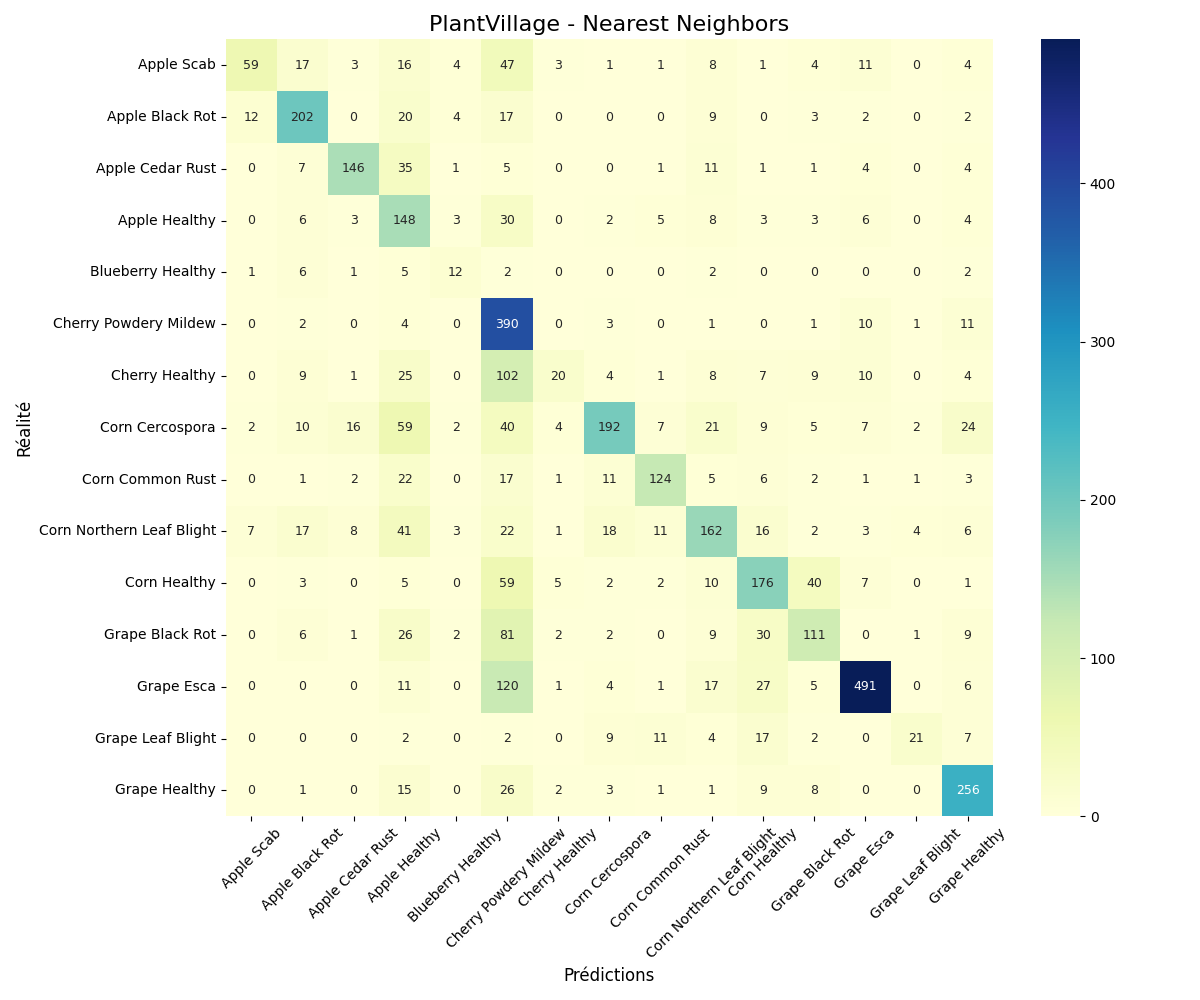
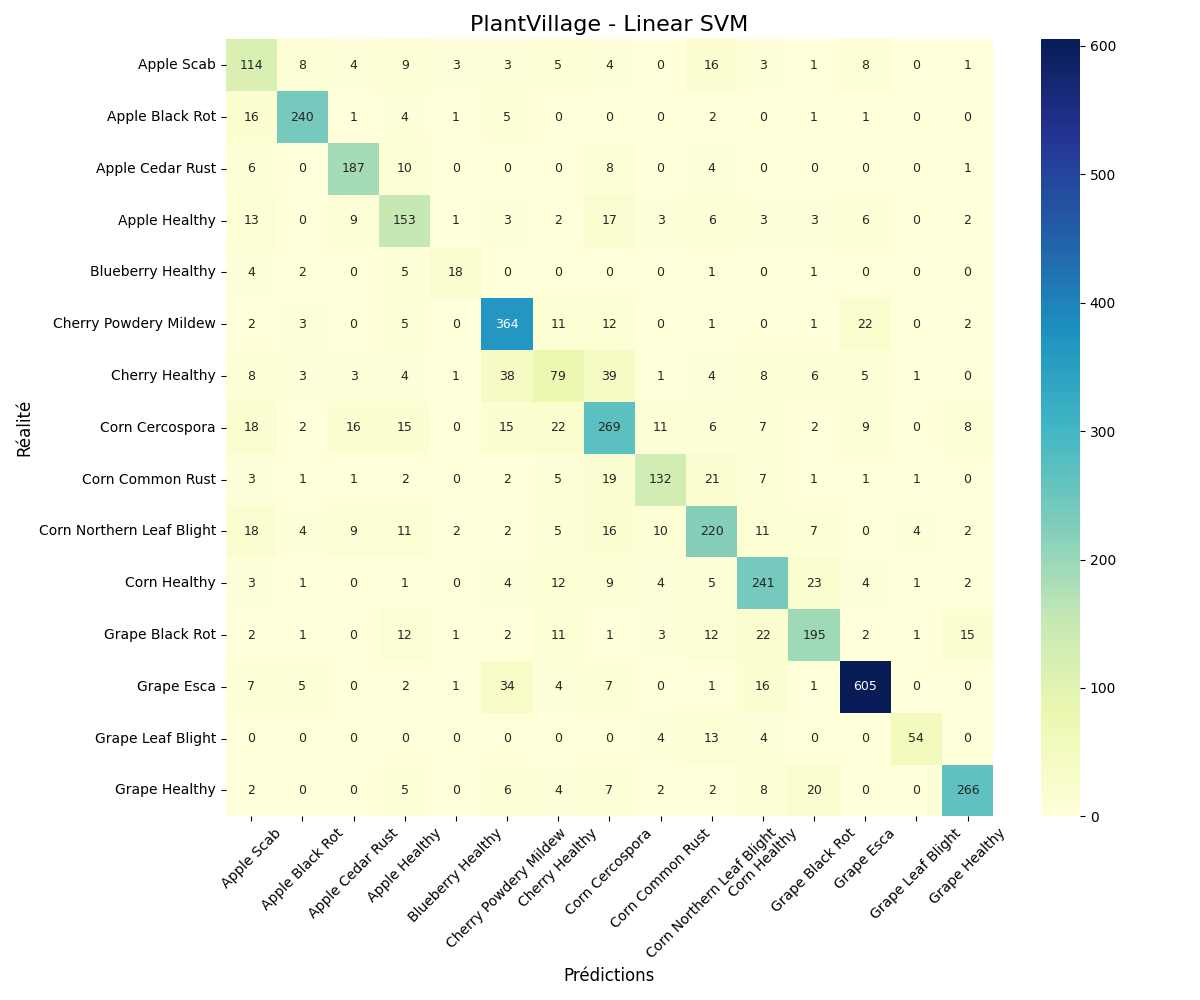
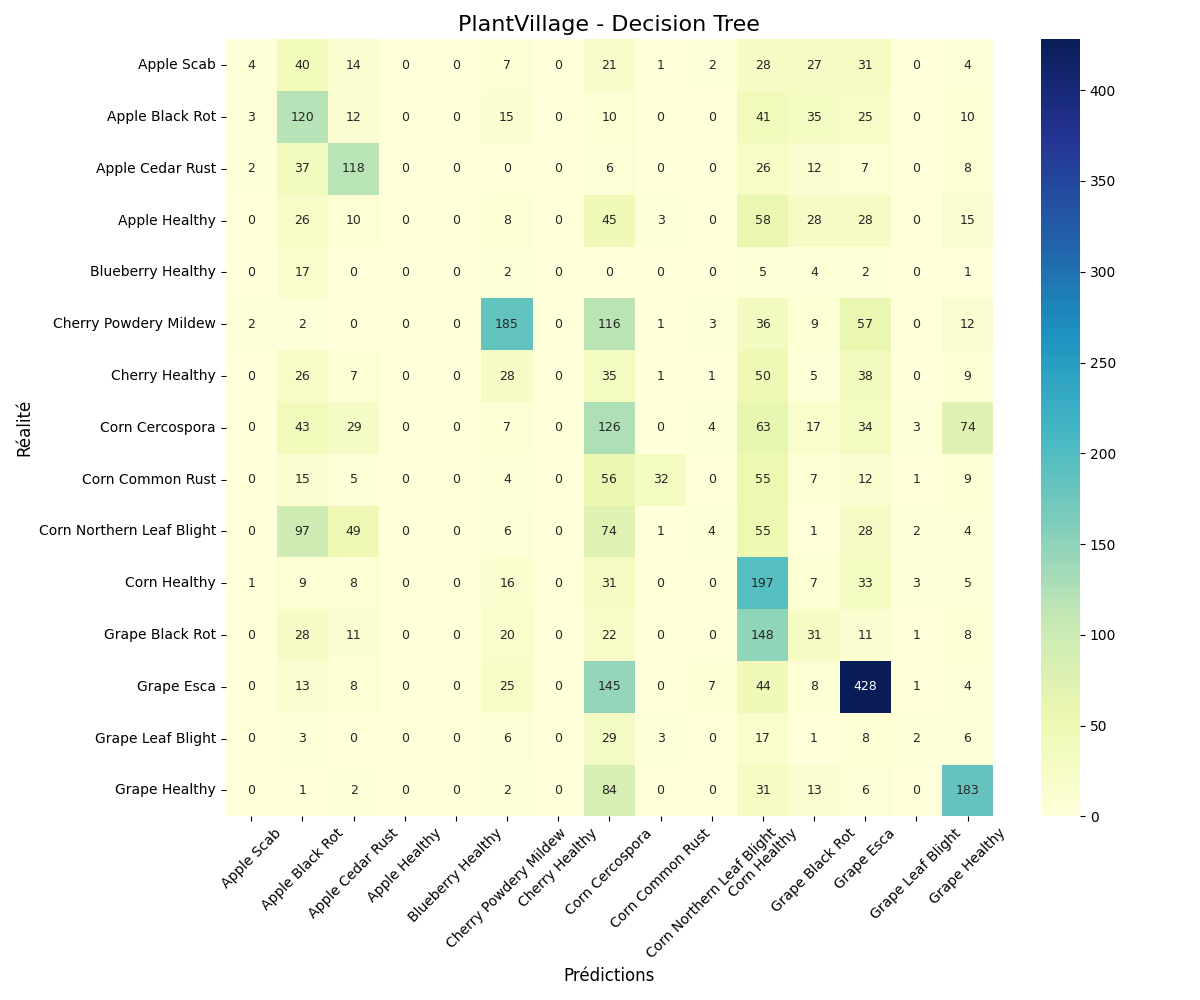
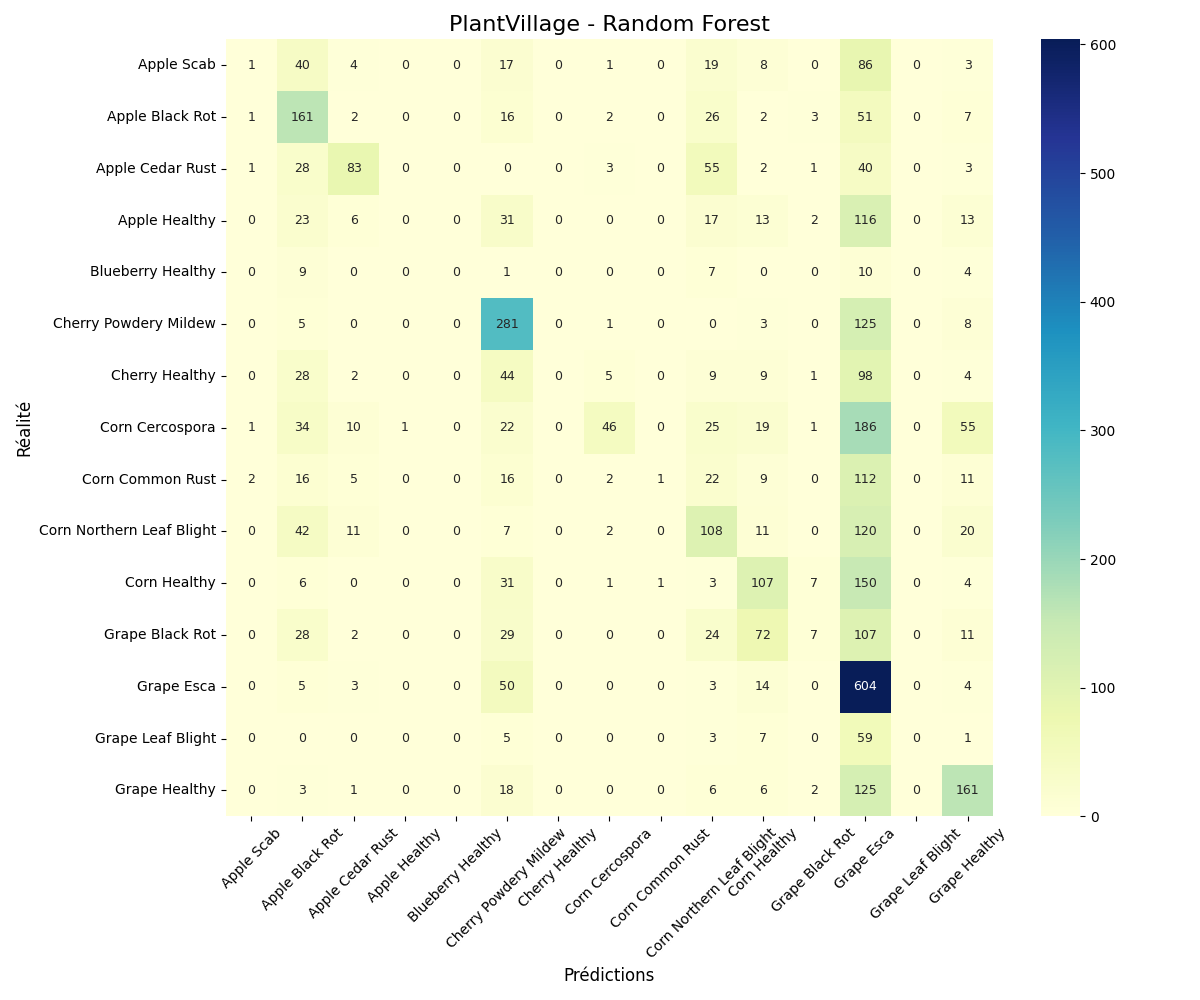
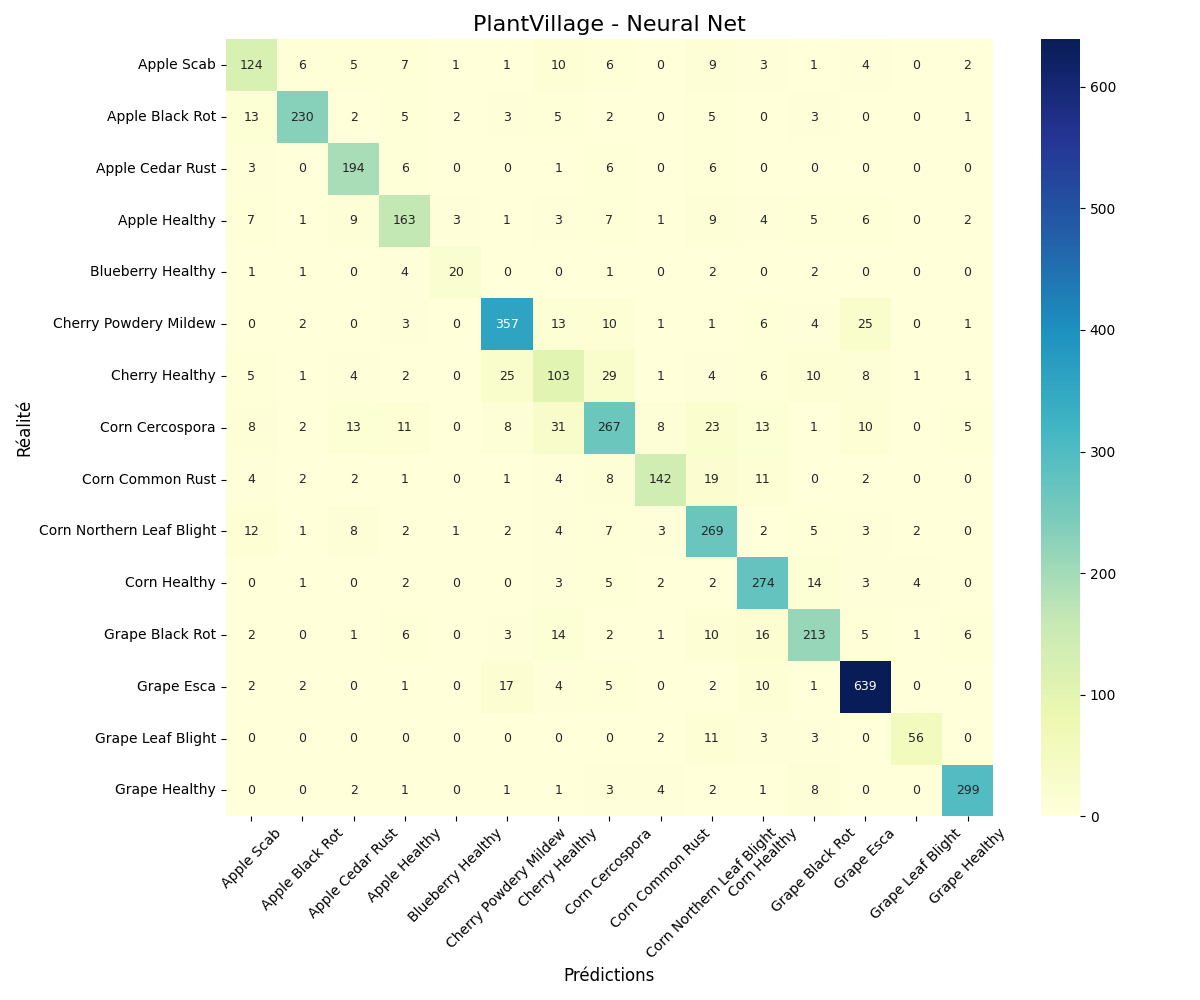
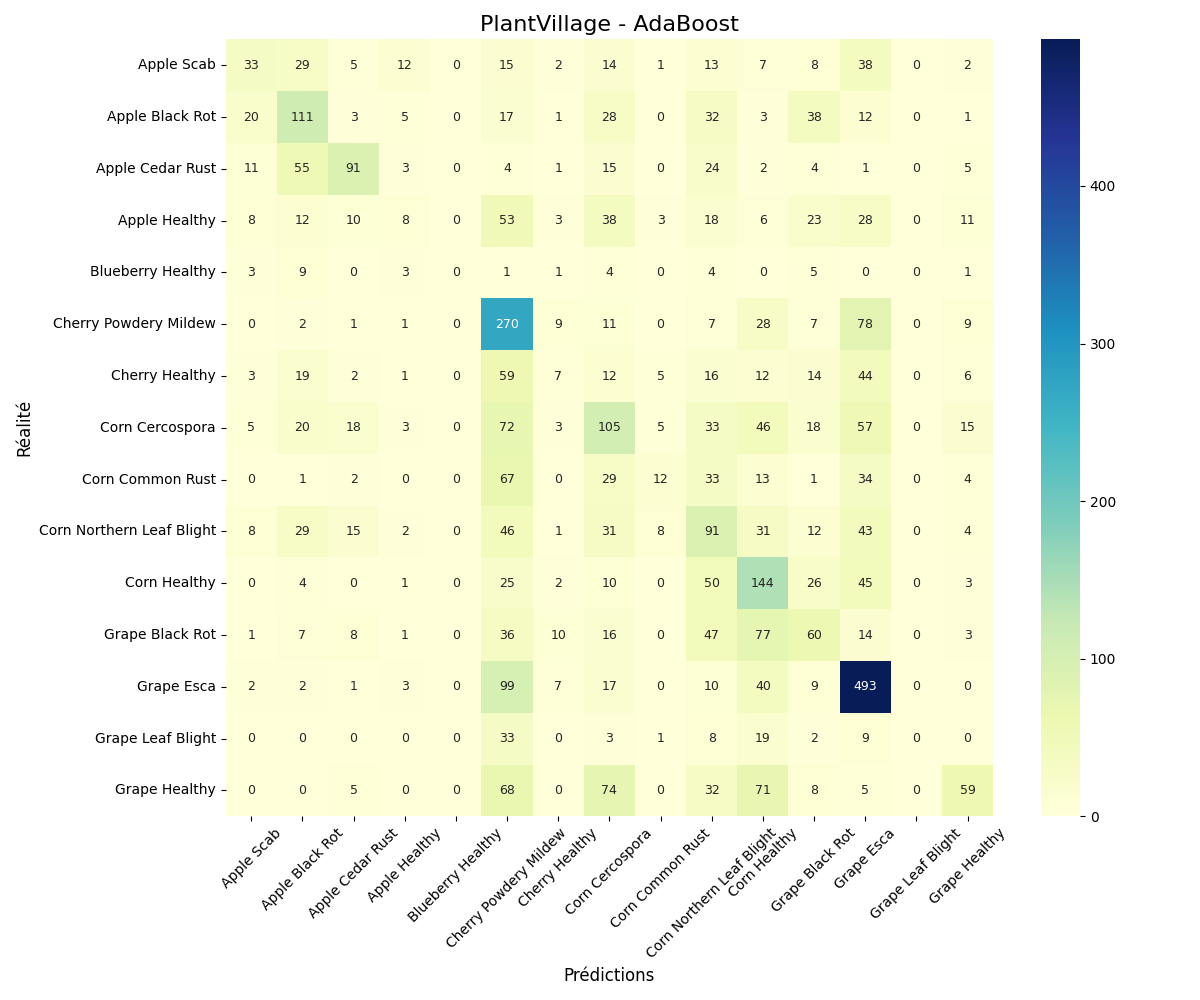
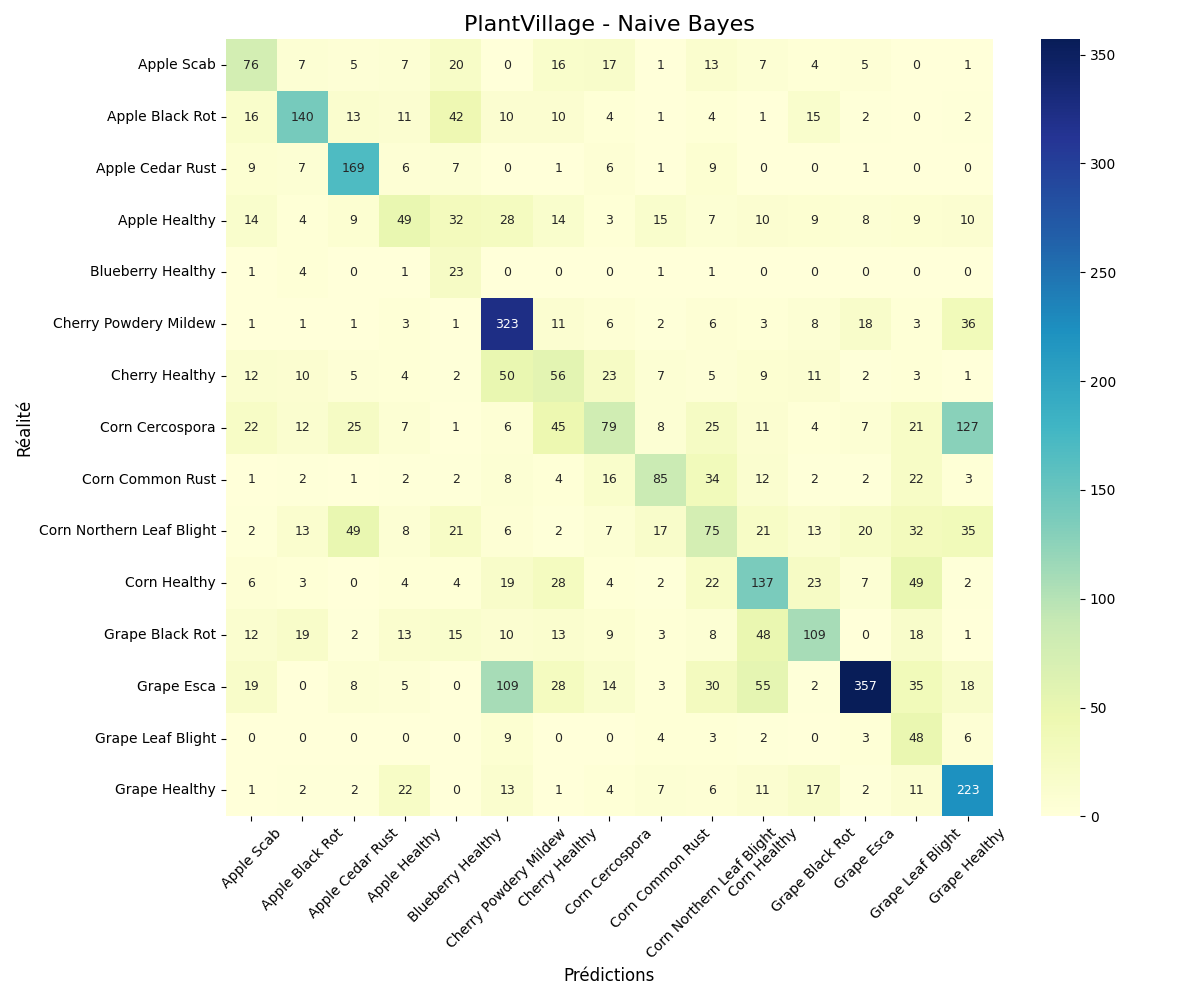
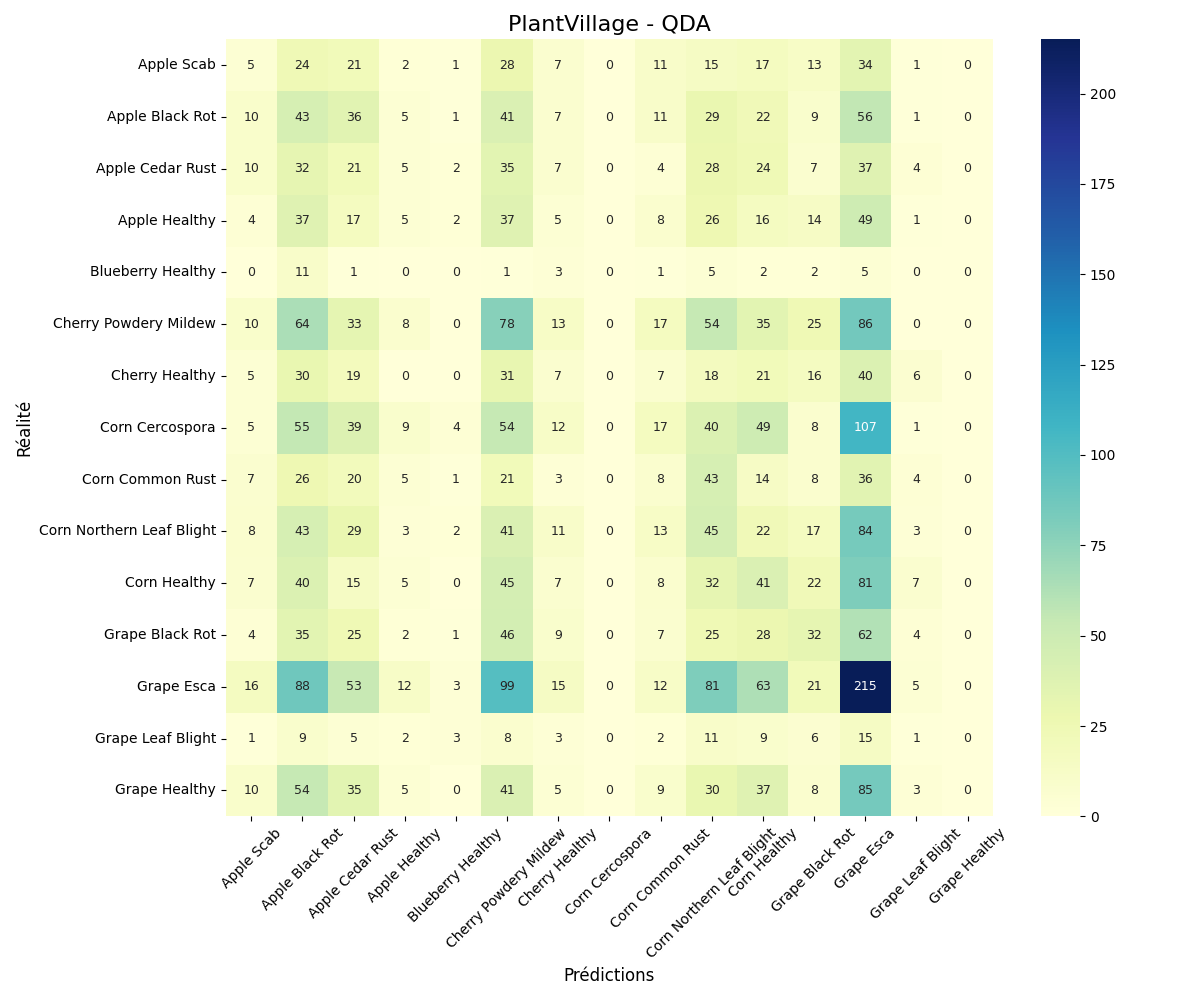
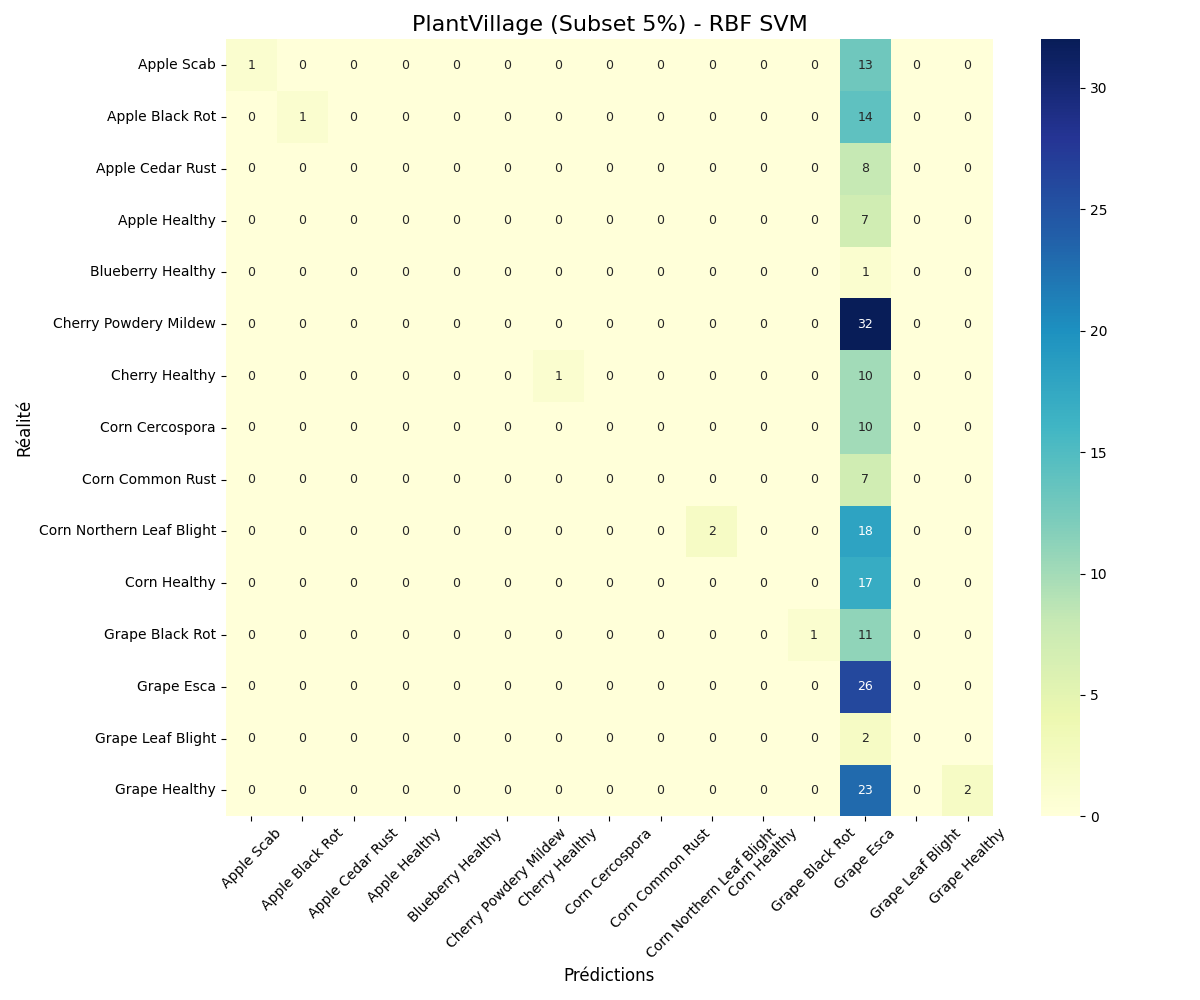
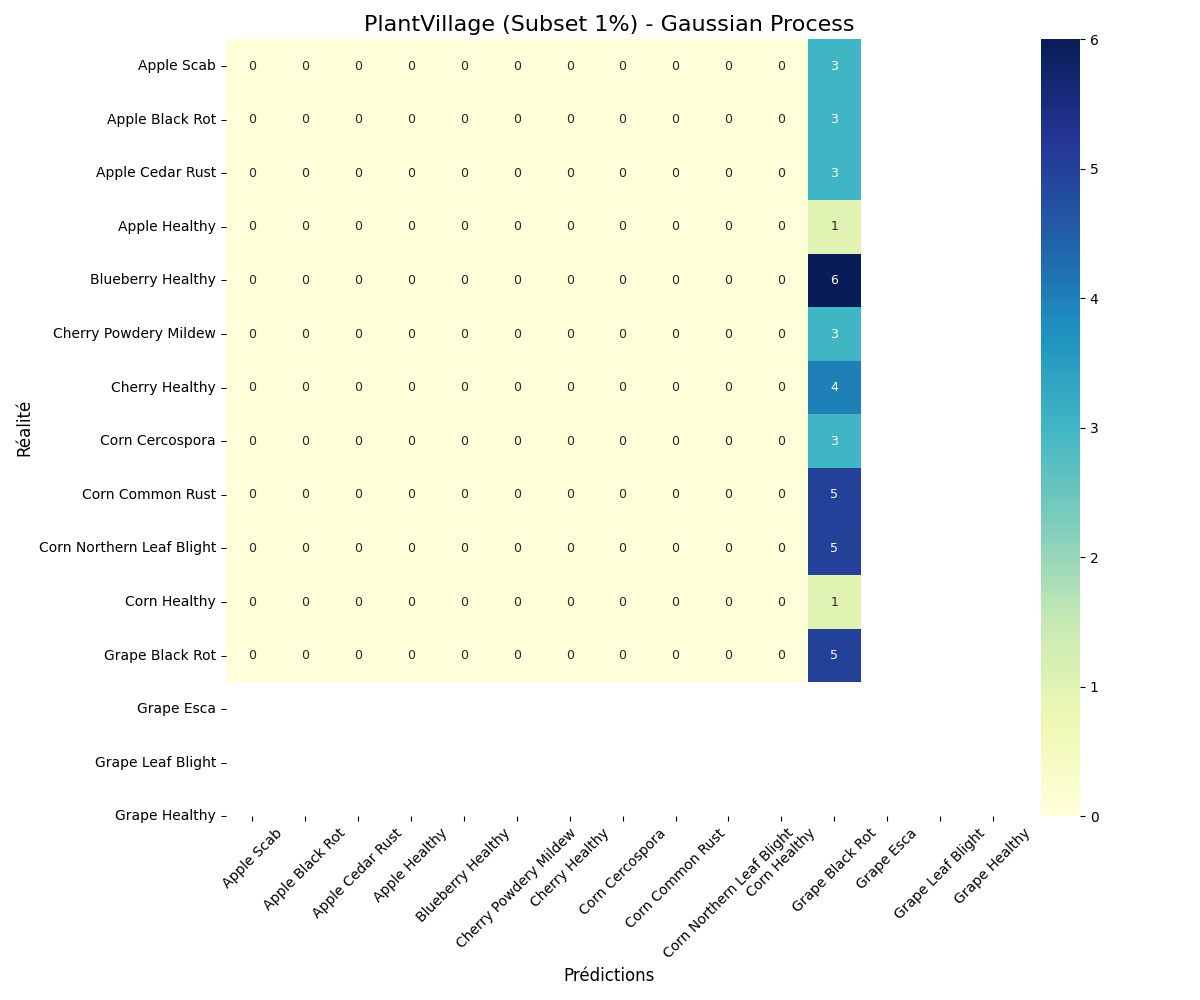

In [ ]:
# Filtrer le dataset souhaité
df_plant = resultats[resultats["Dataset"].str.contains("PlantVillage")].reset_index(drop=True)

tabs_html = """
<style>
.tabs {overflow: hidden; margin-bottom: 10px;}
.tab {float: left; padding: 10px 20px; cursor: pointer; background: #1A231F; color: white; margin-right: 5px; border-radius: 5px;}
.tab:hover {background: #587468;}
.tab.active {background: #587468;}
.tab-content {display: none; padding: 10px; background: #FBF5EE; border-radius: 5px;}
.tab-content.active {display: block;}
</style>

<script>
function openTab(evt, tabName) {
    var i, tabcontent, tablinks;
    tabcontent = document.getElementsByClassName("tab-content");
    for (i = 0; i < tabcontent.length; i++) { tabcontent[i].style.display = "none"; }
    tablinks = document.getElementsByClassName("tab");
    for (i = 0; i < tablinks.length; i++) { tablinks[i].className = tablinks[i].className.replace(" active", ""); }
    document.getElementById(tabName).style.display = "block";
    evt.currentTarget.className += " active";
}
</script>

<div class="tabs">
"""

# Générer les boutons des tabs
for idx in range(len(df_plant)):
    algo = df_plant.loc[idx, 'Algorithme']
    tab_id = f"tab{idx}"
    active_class = "active" if idx == 0 else ""
    tabs_html += f'<div class="tab {active_class}" onclick="openTab(event, \'{tab_id}\')">{algo}</div>'

tabs_html += "</div>"

# Générer le contenu de chaque tab avec image de la matrice intégrée
for idx in range(len(df_plant)):
    algo = df_plant.loc[idx, 'Algorithme']
    dataset = df_plant.loc[idx, 'Dataset']
    cm_json = df_plant.loc[idx, 'confusion_matrix']
    cm_array = np.array(json.loads(cm_json))

    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm_array,
                annot=True,
                fmt="d",
                cmap="YlGnBu",
                cbar=True,
                ax=ax,
                xticklabels=noms_classes,
                yticklabels=noms_classes,
                annot_kws={"size": 9})

    ax.set_title(f"{dataset} - {algo}", fontsize=16)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', rotation=0, labelsize=10)
    ax.set_xlabel("Prédictions", fontsize=12)
    ax.set_ylabel("Réalité", fontsize=12)
    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format="png")
    plt.close(fig)
    data = base64.b64encode(buf.getbuffer()).decode("ascii")
    tab_id = f"tab{idx}"
    active_style = "style='display:block;'" if idx == 0 else ""
    tabs_html += f"""
    <div id="{tab_id}" class="tab-content" {active_style}>
        <img src="data:image/png;base64,{data}" style="max-width:100%; height:auto; border-radius:5px;">
    </div>
    """

display(HTML(tabs_html))


Des onglets sont disponibles pour visualiser les différentes matrices de confusion selon les différents algorithmes.

**Visualisation des matrices de confusion - MNIST**


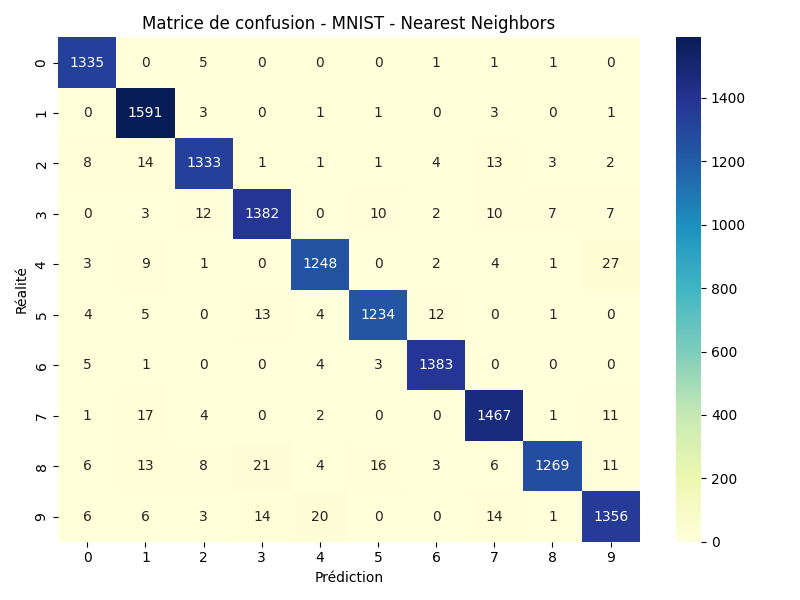
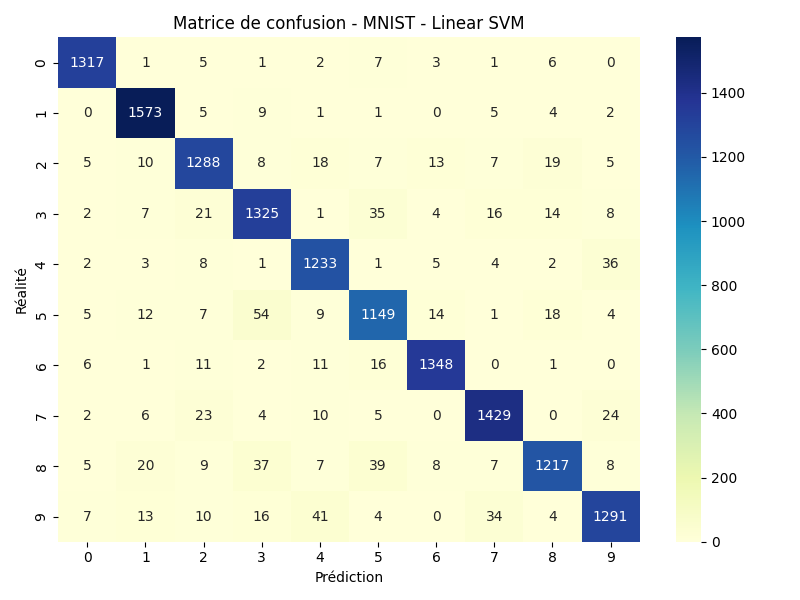
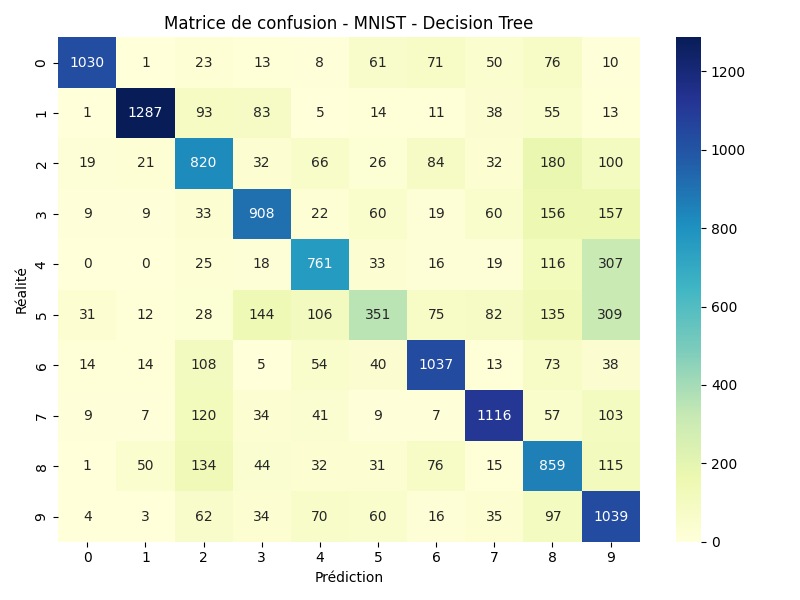
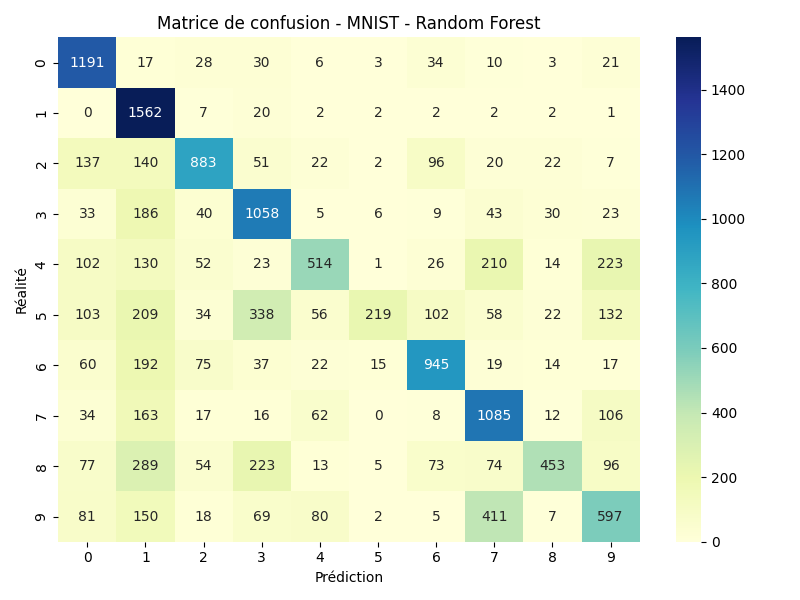
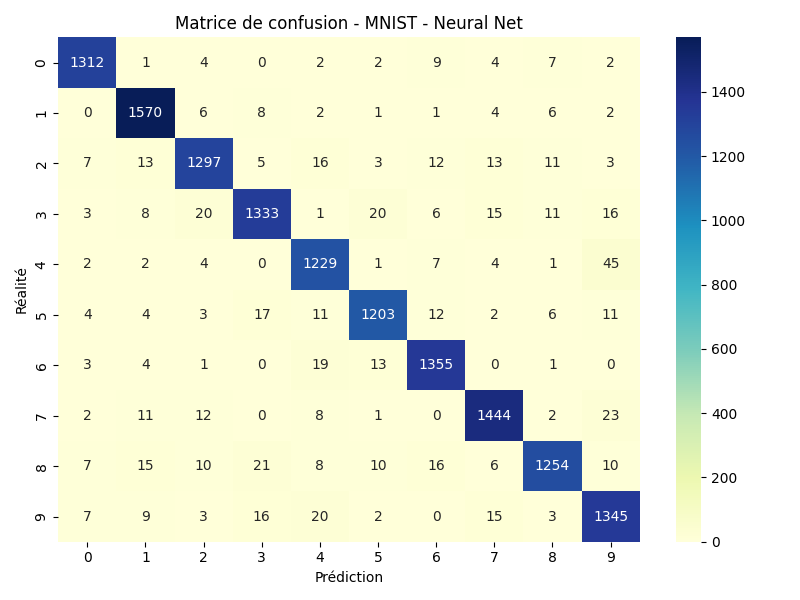
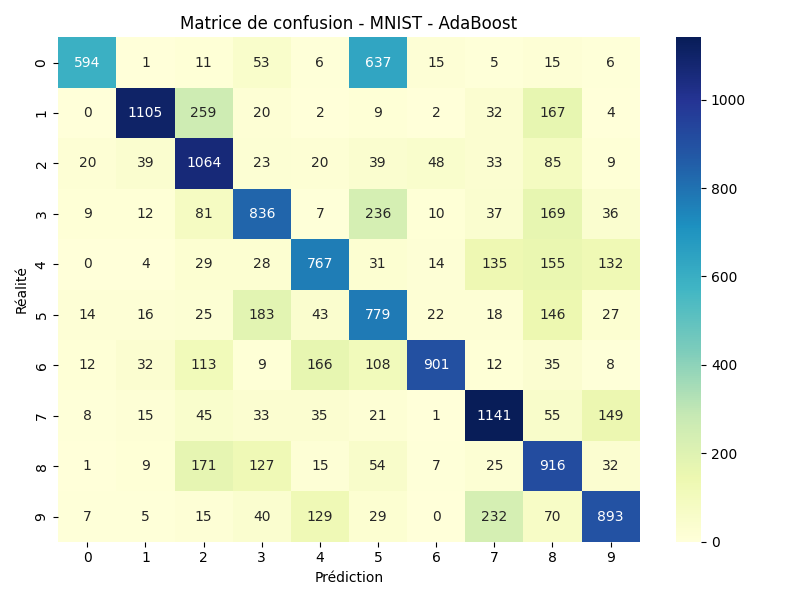
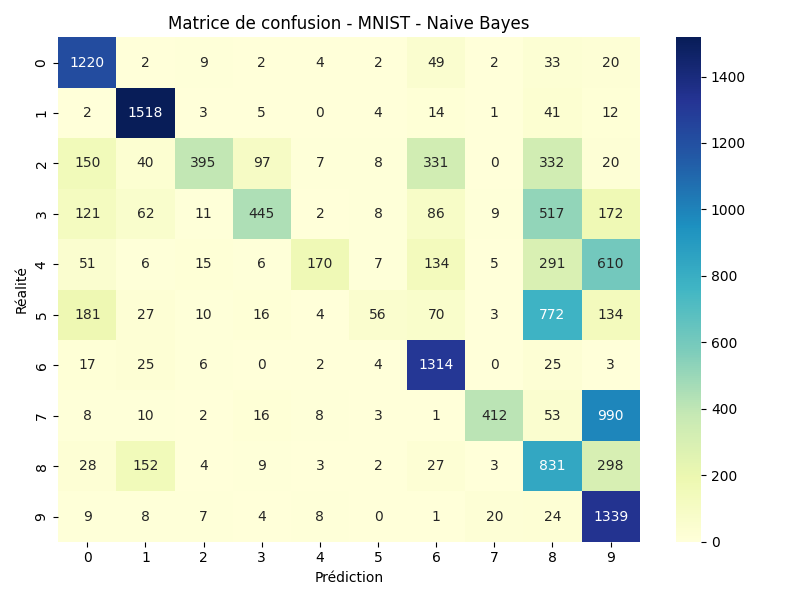
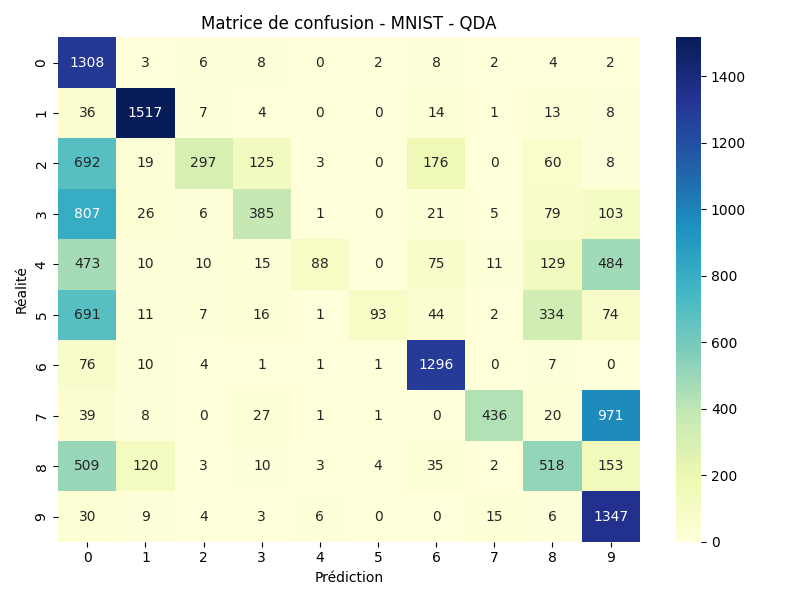
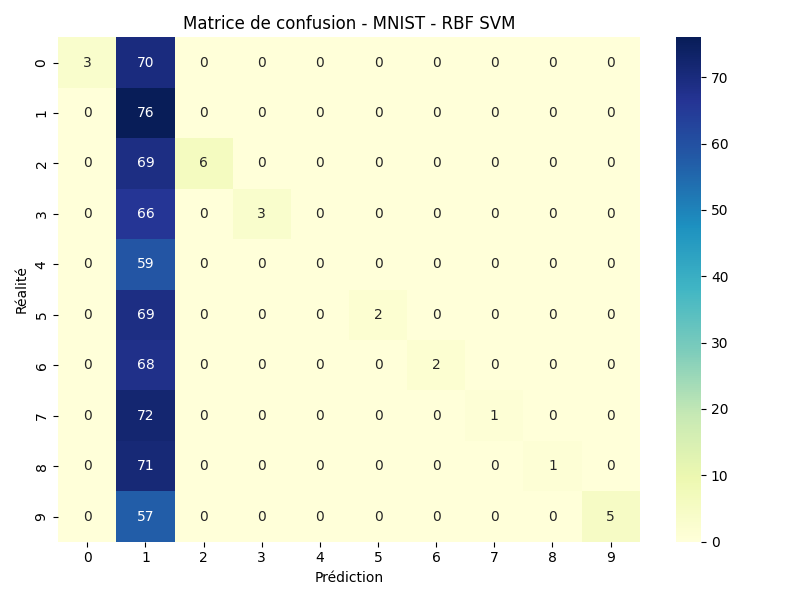
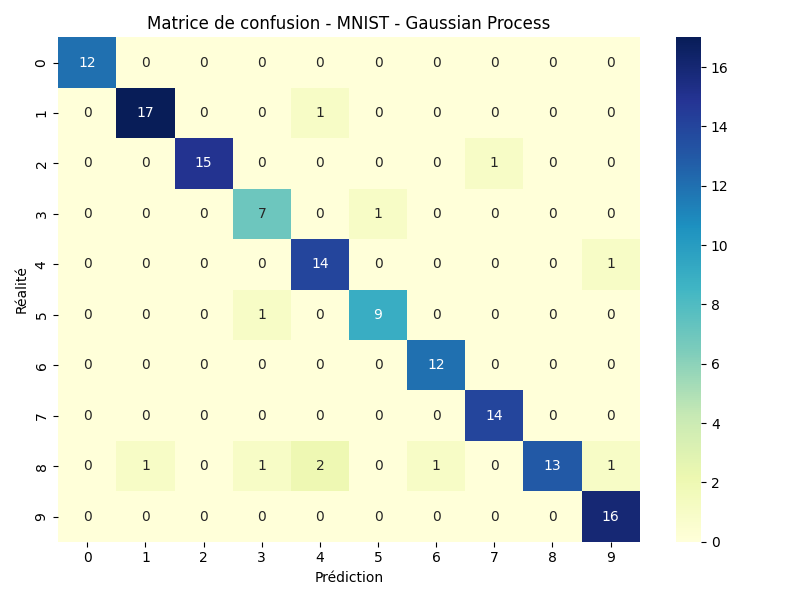

In [ ]:
dataset_cible = "MNIST"
resultats_cible = resultats[resultats["Dataset"].str.contains(dataset_cible)]
noms_classes_utilises = noms_classes if dataset_cible == "PlantVillage" else [str(i) for i in range(resultats_cible.iloc[0]["confusion_matrix"].count("[") - 1)]

def plot_to_base64(cm_array, algo_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_array, annot=True, fmt="d", cmap="YlGnBu", cbar=True,
                xticklabels=noms_classes_utilises[:cm_array.shape[0]],
                yticklabels=noms_classes_utilises[:cm_array.shape[0]])
    plt.title(f"Matrice de confusion - {dataset_cible} - {algo_name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Réalité")
    buf = BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format="png")
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode('utf-8')


tabs_html = '<div class="tabs">'
content_html = ""

for idx, row in resultats_cible.iterrows():
    algo_name = row["Algorithme"]
    cm_json = row["confusion_matrix"]
    cm_array = np.array(json.loads(cm_json))

    img_base64 = plot_to_base64(cm_array, algo_name)


    tab_id = f"tab_{idx}"
    tabs_html += f'<button class="tablink" onclick="openTab(event, \'{tab_id}\')">{algo_name}</button>\n'
    content_html += f'''
    <div id="{tab_id}" class="tabcontent" style="display:none;">
        <img src="data:image/png;base64,{img_base64}" style="max-width: 100%; height: auto;">
    </div>
    '''

tabs_html += '</div>'

style_js_css = """
<style>
.tablink {background-color: #1A231F; color: white; padding: 10px 15px; cursor: pointer; display: inline-block; border: none; border-radius: 4px; margin-right: 4px;}
.tablink:hover {background-color: #587468;}
.tabcontent {display: none; padding: 10px; background-color: #FBF5EE; border-radius: 6px; margin-top: 10px;}
</style>

<script>
function openTab(evt, tabName) {
    var i, tabcontent, tablinks;
    tabcontent = document.getElementsByClassName("tabcontent");
    for (i = 0; i < tabcontent.length; i++) {tabcontent[i].style.display = "none";}
    tablinks = document.getElementsByClassName("tablink");
    for (i = 0; i < tablinks.length; i++) {tablinks[i].style.backgroundColor = "#1A231F";}
    document.getElementById(tabName).style.display = "block";
    evt.currentTarget.style.backgroundColor = "#587468";
}
</script>
"""


full_html = style_js_css + tabs_html + content_html
display(HTML(full_html))

Des onglets sont disponibles pour visualiser les différentes matrices de confusion selon les différents algorithmes.

**Visualisation des matrices de confusion - Iris**


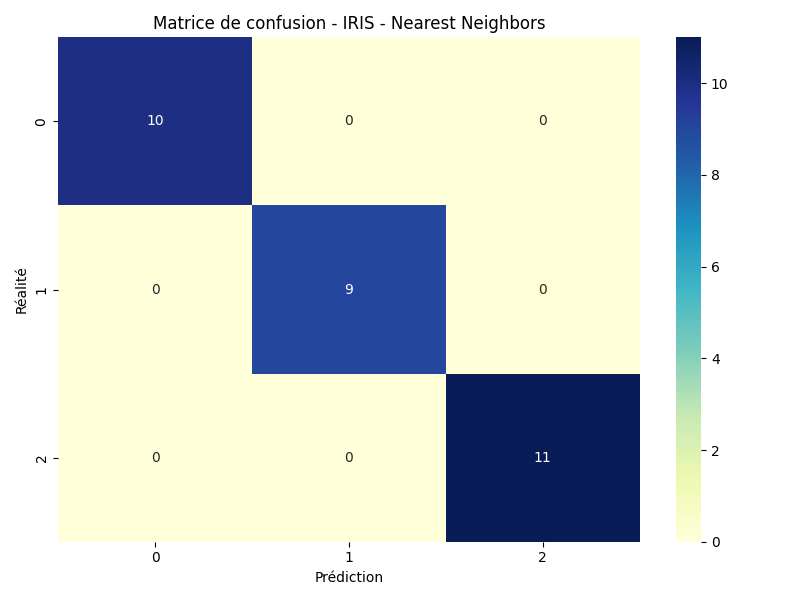
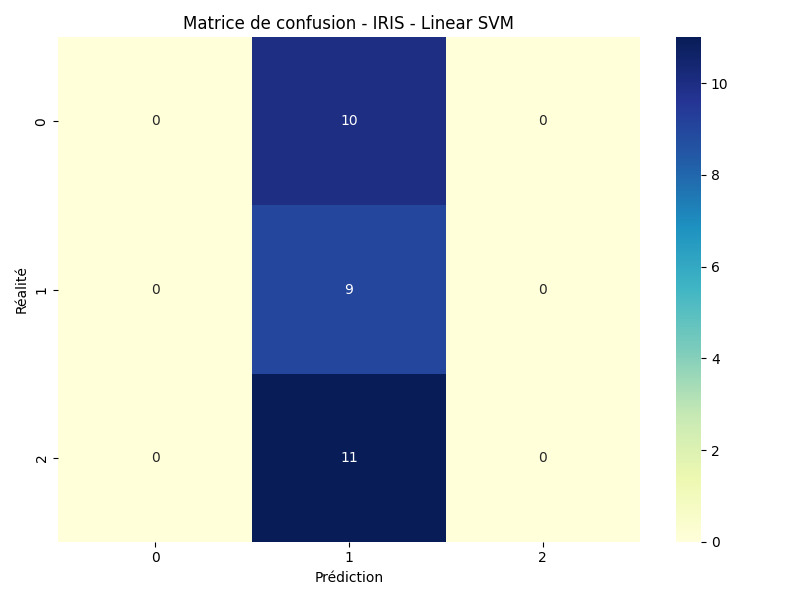
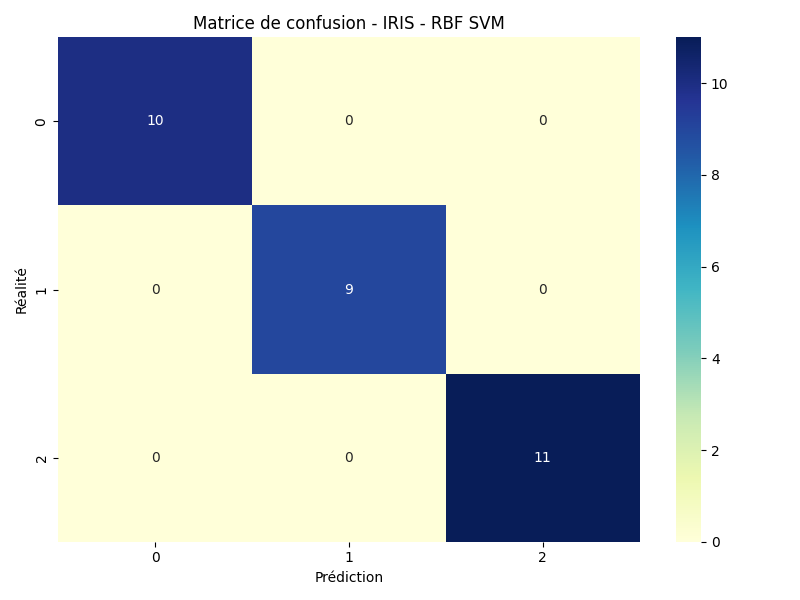
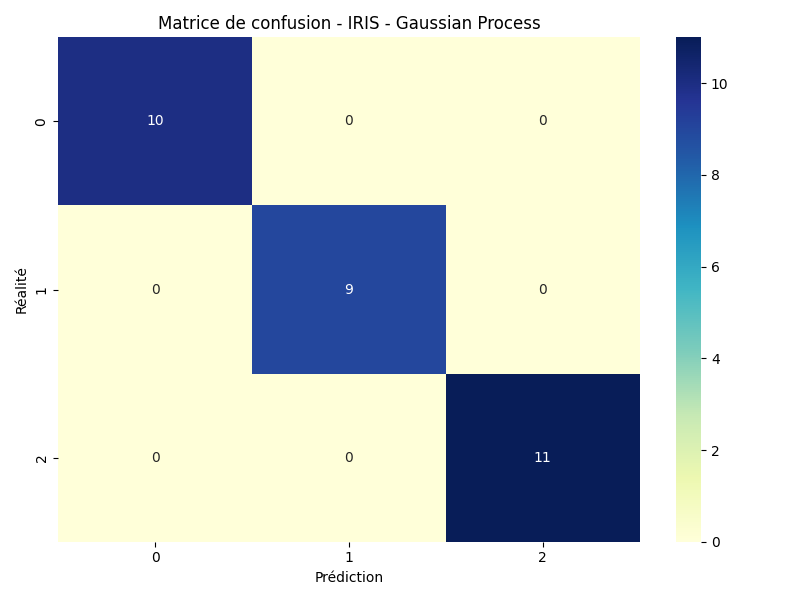
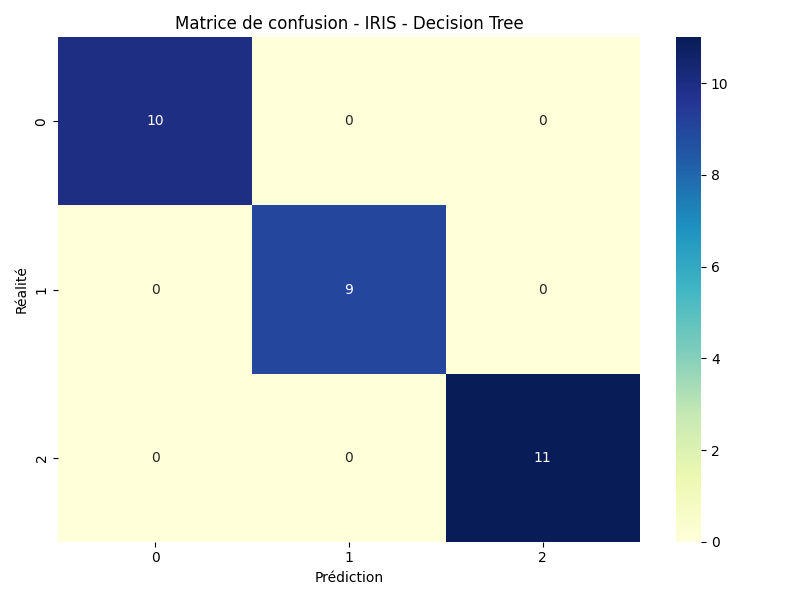
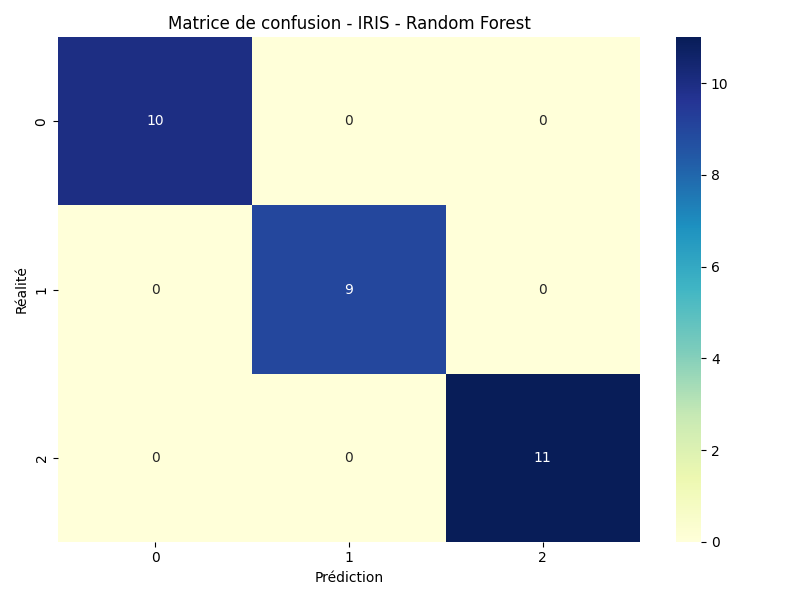
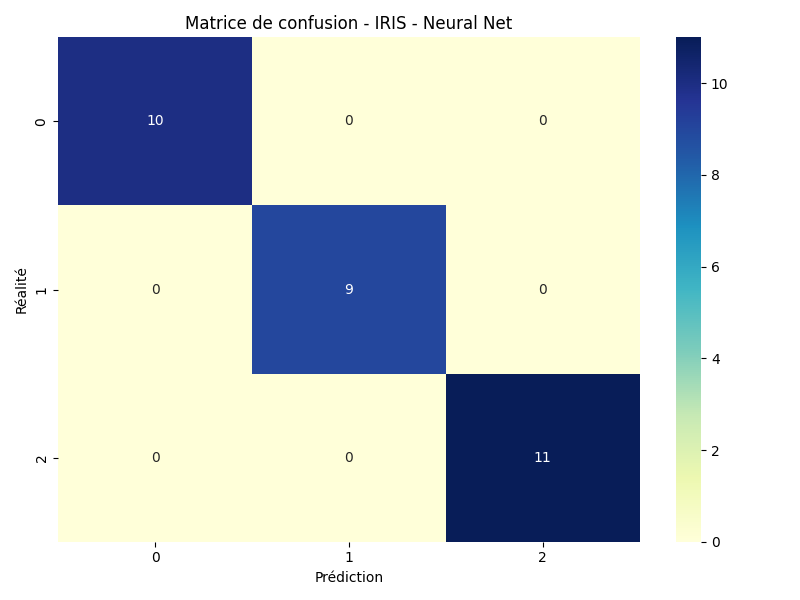
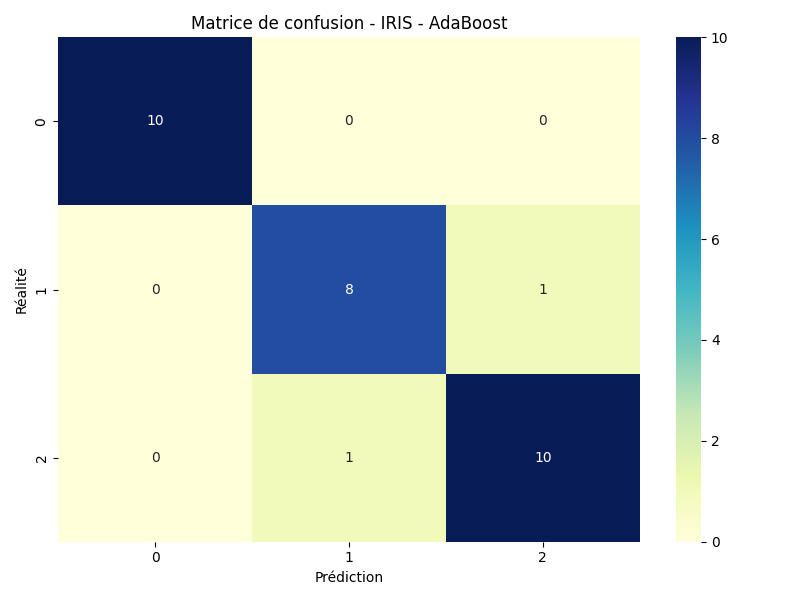
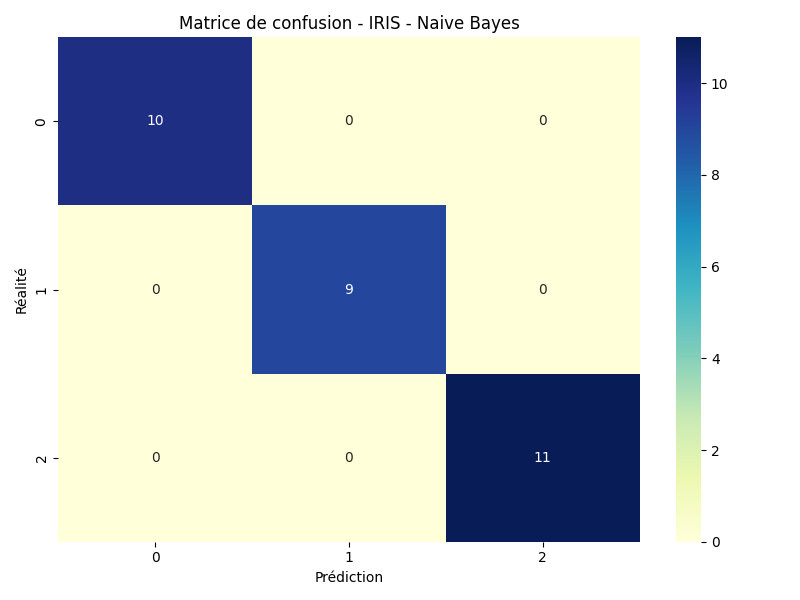
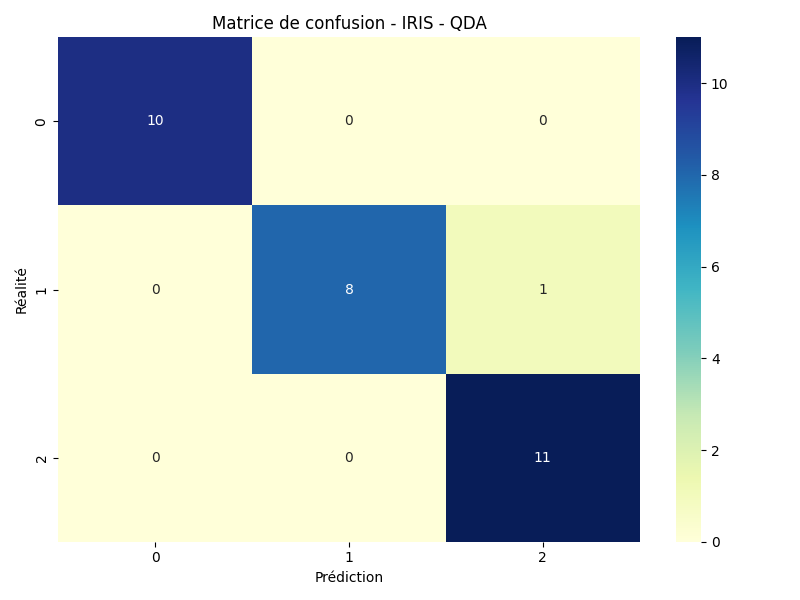

In [ ]:
dataset_cible = "IRIS"
resultats_cible = resultats[resultats["Dataset"].str.contains(dataset_cible)]
noms_classes_utilises = noms_classes if dataset_cible == "PlantVillage" else [str(i) for i in range(resultats_cible.iloc[0]["confusion_matrix"].count("[") - 1)]

def plot_to_base64(cm_array, algo_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_array, annot=True, fmt="d", cmap="YlGnBu", cbar=True,
                xticklabels=noms_classes_utilises[:cm_array.shape[0]],
                yticklabels=noms_classes_utilises[:cm_array.shape[0]])
    plt.title(f"Matrice de confusion - {dataset_cible} - {algo_name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Réalité")
    buf = BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format="png")
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode('utf-8')


tabs_html = '<div class="tabs">'
content_html = ""

for idx, row in resultats_cible.iterrows():
    algo_name = row["Algorithme"]
    cm_json = row["confusion_matrix"]
    cm_array = np.array(json.loads(cm_json))


    img_base64 = plot_to_base64(cm_array, algo_name)


    tab_id = f"tab_{idx}"
    tabs_html += f'<button class="tablink" onclick="openTab(event, \'{tab_id}\')">{algo_name}</button>\n'
    content_html += f'''
    <div id="{tab_id}" class="tabcontent" style="display:none;">
        <img src="data:image/png;base64,{img_base64}" style="max-width: 100%; height: auto;">
    </div>
    '''

tabs_html += '</div>'


style_js_css = """
<style>
.tablink {background-color: #1A231F; color: white; padding: 10px 15px; cursor: pointer; display: inline-block; border: none; border-radius: 4px; margin-right: 4px;}
.tablink:hover {background-color: #587468;}
.tabcontent {display: none; padding: 10px; background-color: #FBF5EE; border-radius: 6px; margin-top: 10px;}
</style>

<script>
function openTab(evt, tabName) {
    var i, tabcontent, tablinks;
    tabcontent = document.getElementsByClassName("tabcontent");
    for (i = 0; i < tabcontent.length; i++) {tabcontent[i].style.display = "none";}
    tablinks = document.getElementsByClassName("tablink");
    for (i = 0; i < tablinks.length; i++) {tablinks[i].style.backgroundColor = "#1A231F";}
    document.getElementById(tabName).style.display = "block";
    evt.currentTarget.style.backgroundColor = "#587468";
}
</script>
"""


full_html = style_js_css + tabs_html + content_html
display(HTML(full_html))

Des onglets sont disponibles pour visualiser les différentes matrices de confusion selon les différents algorithmes.

**Visualisation par graphique**


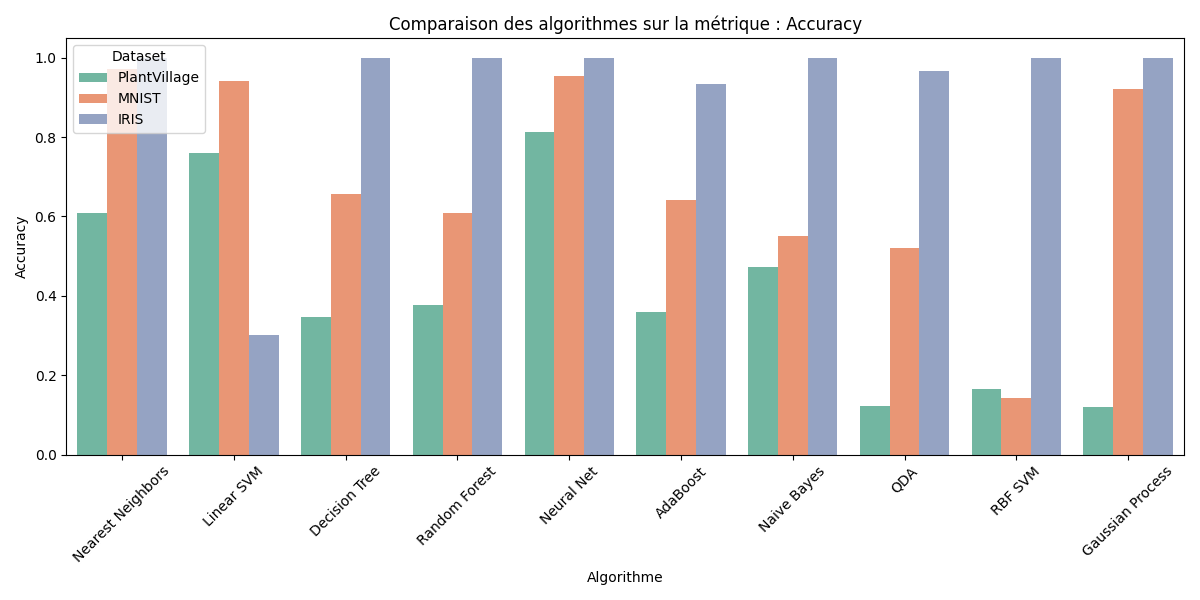
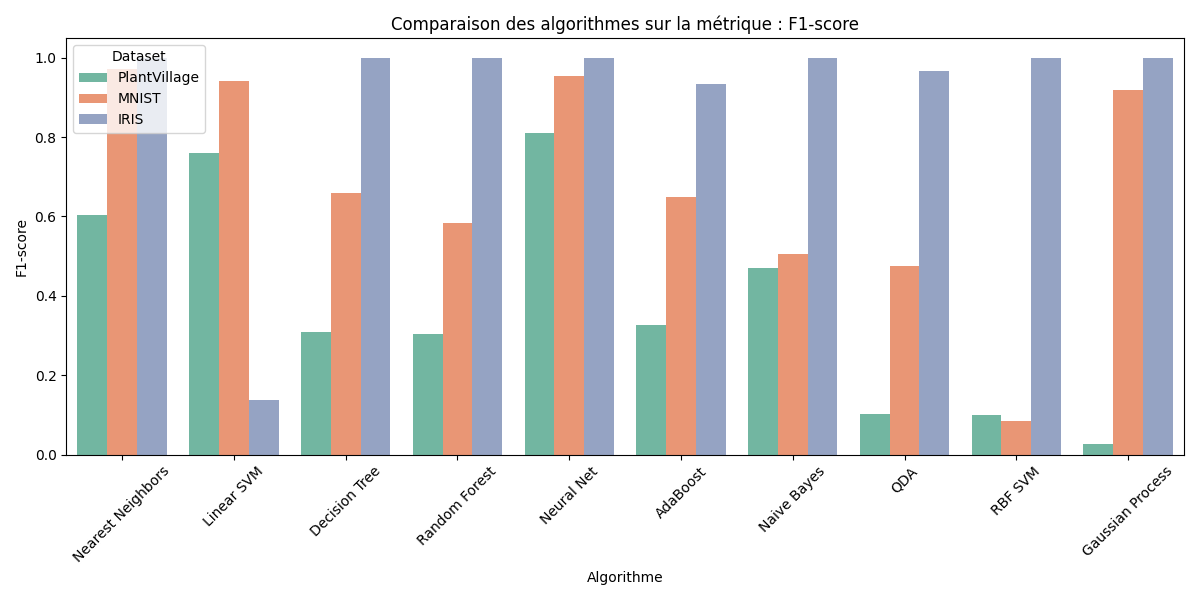
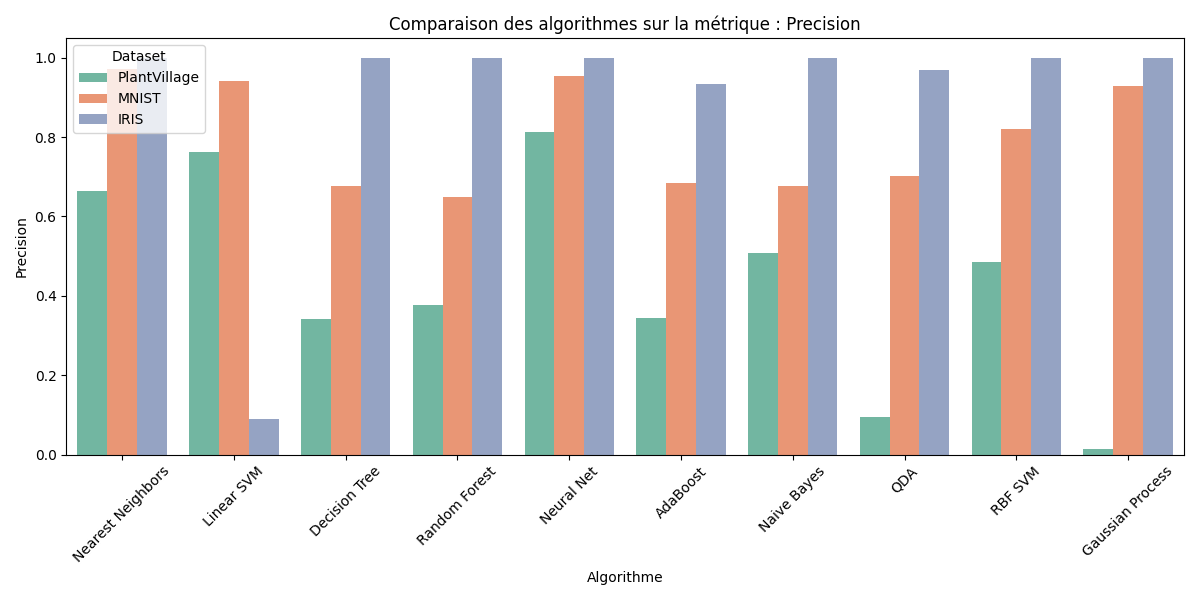
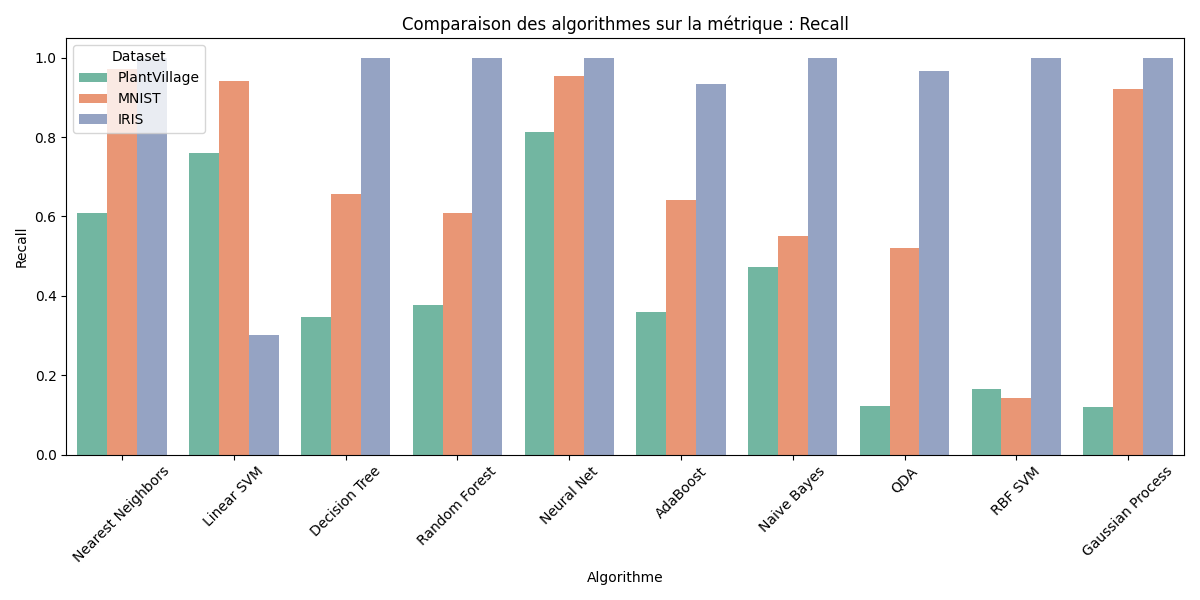
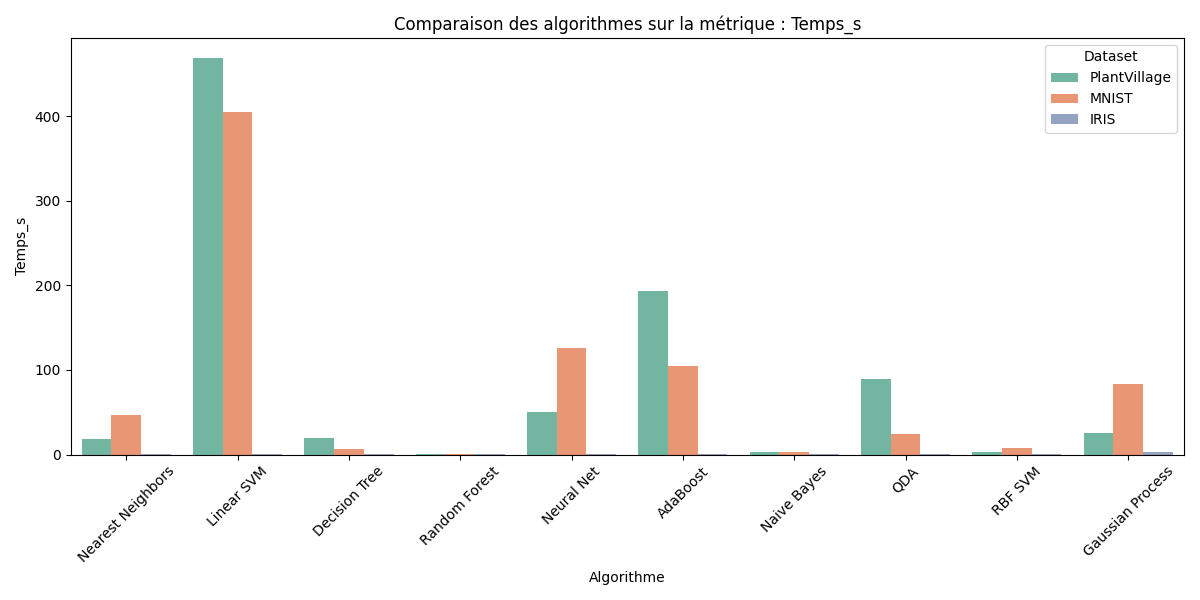
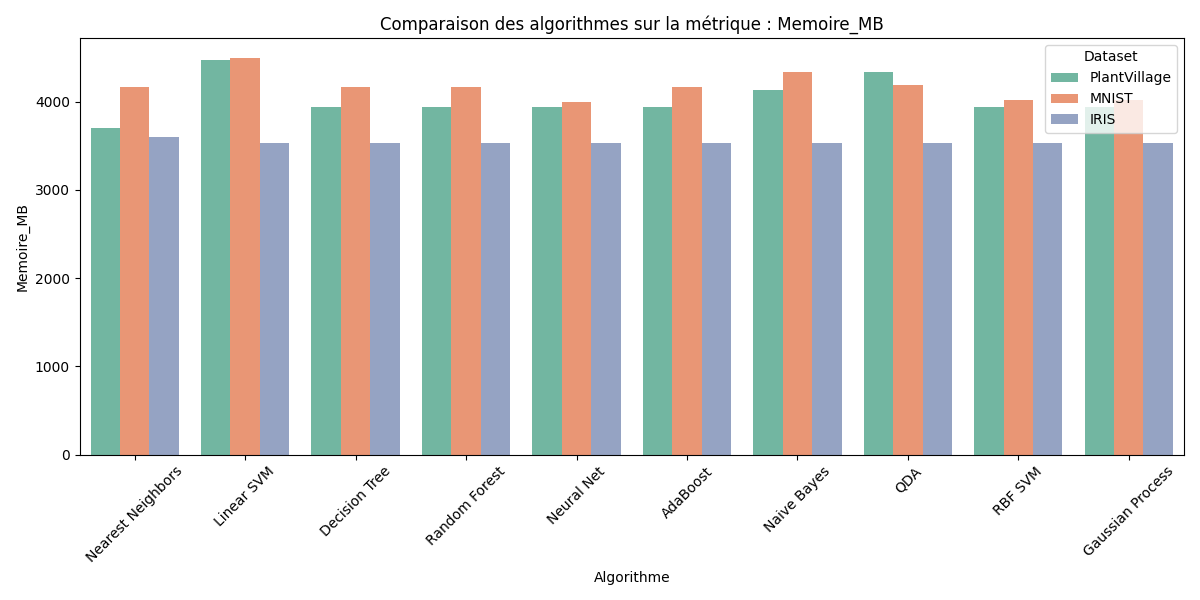

In [ ]:
metrics = ["Accuracy", "F1-score", "Precision", "Recall", "Temps_s", "Memoire_MB"]
datasets_names = ["MNIST", "PlantVillage", "IRIS"]

df_plot = resultats[["Dataset", "Algorithme"] + metrics].copy()
df_plot["Dataset"] = df_plot["Dataset"].str.replace(r"\s\(Subset.*\)", "", regex=True)
palette = sns.color_palette("Set2", n_colors=len(datasets_names))


def plot_metric_to_base64(metric):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(
        data=df_plot,
        x="Algorithme",
        y=metric,
        hue="Dataset",
        palette=palette,
        ax=ax
    )
    ax.set_title(f"Comparaison des algorithmes sur la métrique : {metric}")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Dataset")
    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format="png")
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode('utf-8')


tabs_html = '<div class="tabs">'
content_html = ""

for metric in metrics:
    img_base64 = plot_metric_to_base64(metric)
    tab_id = f"tab_{metric.replace('-', '_')}"
    tabs_html += f'<button class="tablink" onclick="openTab(event, \'{tab_id}\')">{metric}</button>\n'
    content_html += f'''
    <div id="{tab_id}" class="tabcontent" style="display:none;">
        <img src="data:image/png;base64,{img_base64}" style="max-width: 100%; height: auto;">
    </div>
    '''

tabs_html += '</div>'

style_js_css = """
<style>
.tablink {
    background-color: #1A231F;
    color: white;
    padding: 10px 15px;
    cursor: pointer;
    display: inline-block;
    border: none;
    border-radius: 4px;
    margin-right: 4px;
}
.tablink:hover {background-color: #587468;}
.tabcontent {display: none; padding: 10px; background-color: #FBF5EE; margin-top: 10px;}
</style>

<script>
function openTab(evt, tabName) {
    var i, tabcontent, tablinks;
    tabcontent = document.getElementsByClassName("tabcontent");
    for (i = 0; i < tabcontent.length; i++) {tabcontent[i].style.display = "none";}
    tablinks = document.getElementsByClassName("tablink");
    for (i = 0; i < tablinks.length; i++) {tablinks[i].style.backgroundColor = "#1A231F";}
    document.getElementById(tabName).style.display = "block";
    evt.currentTarget.style.backgroundColor = "#587468";
}
</script>
"""

full_html = style_js_css + tabs_html + content_html
display(HTML(full_html))


Des onglets sont disponibles pour visualiser les différents graphiques selon les différentes métriques.

**Visualisation par nuage de données- PlantVillage**

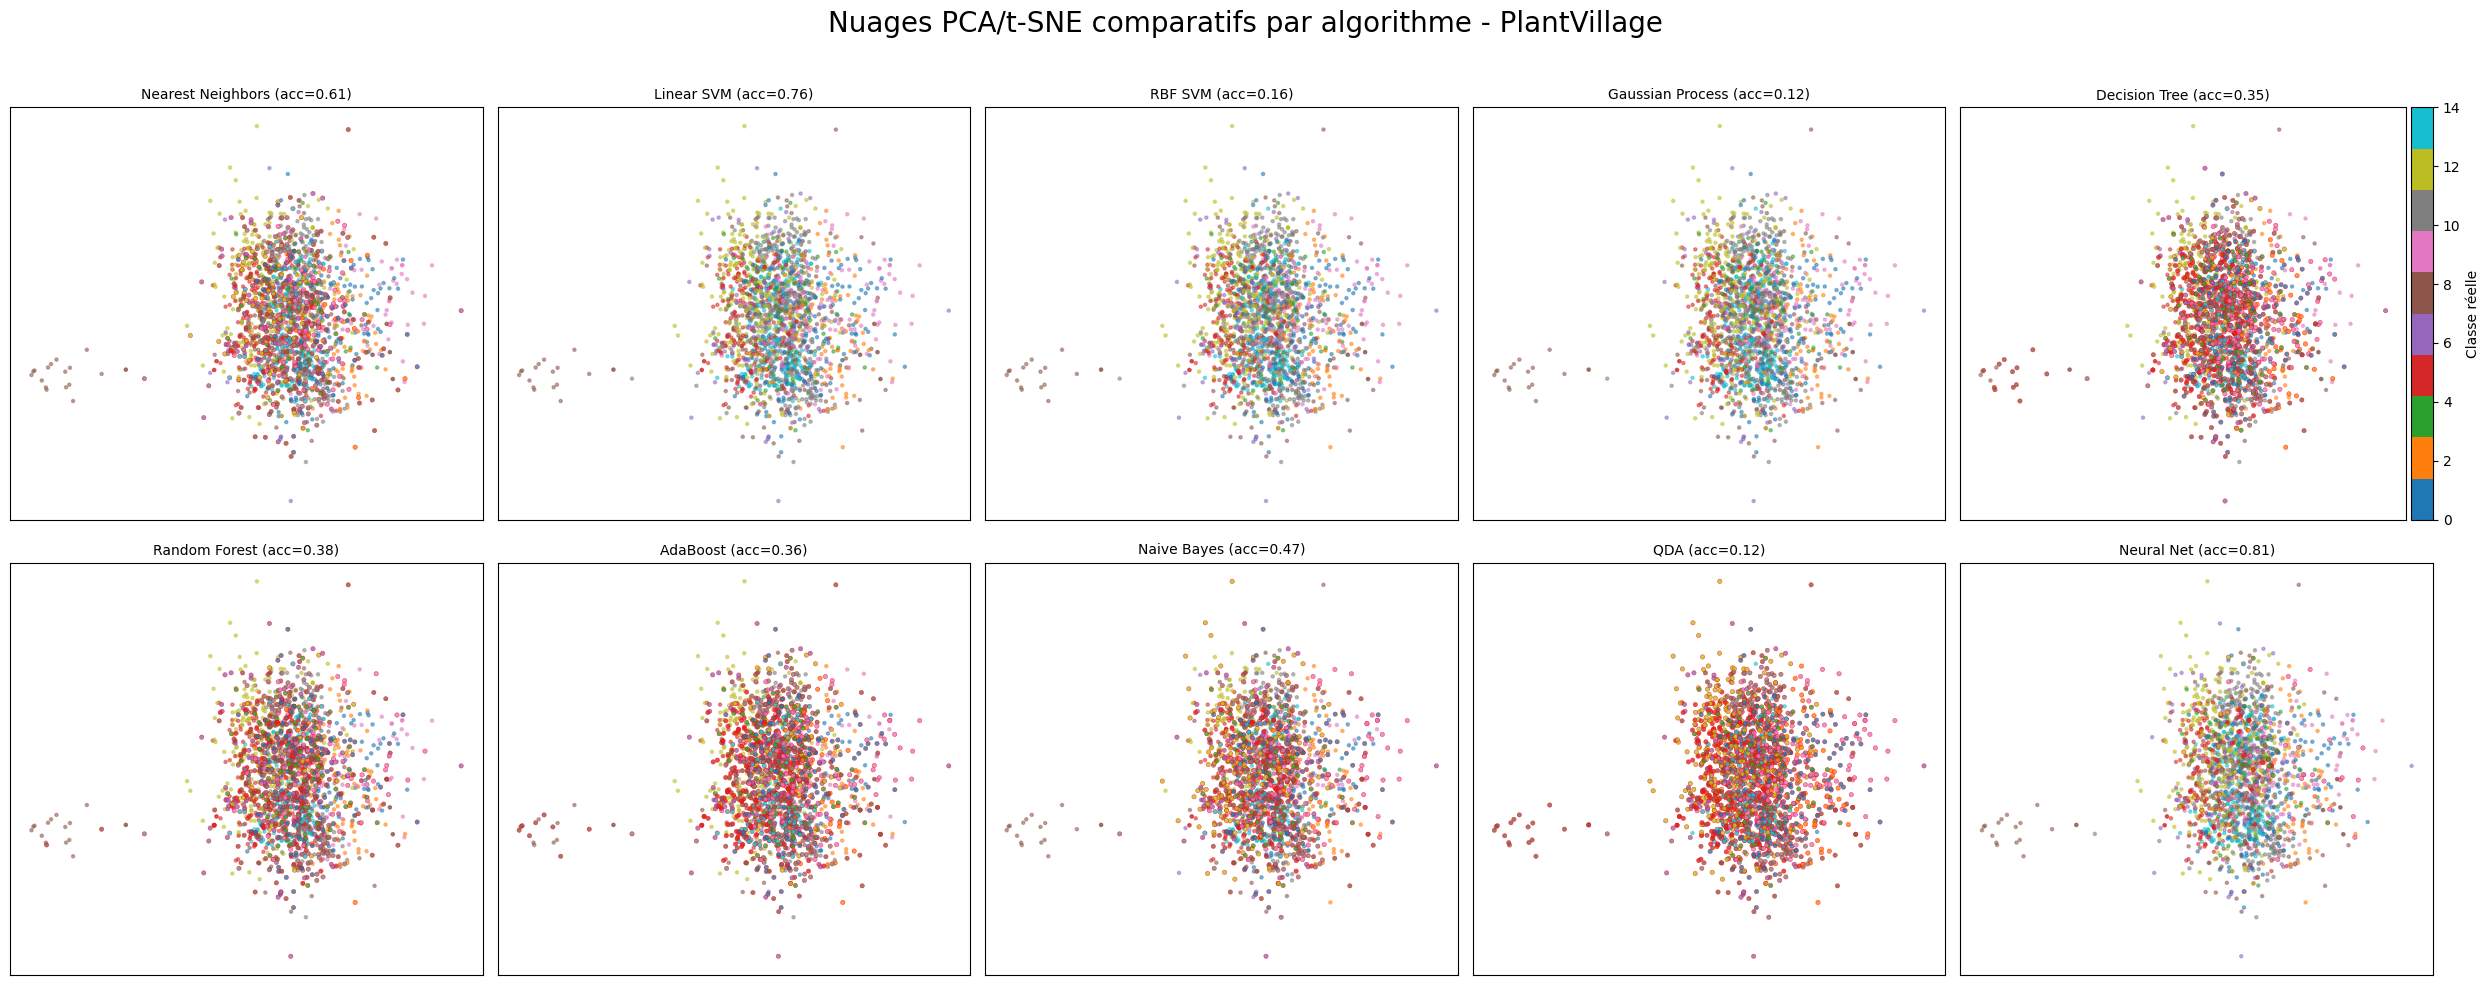

In [ ]:
dataset_cible = "PlantVillage"

# Charger tes X et y correspondants ici
if dataset_cible == "MNIST":
    X = X_mnist_normalized
    y = y_mnist
    # Réduction pour accélérer le rendu :
    from sklearn.utils import resample
    X, y = resample(X, y, n_samples=3000, random_state=42)
elif dataset_cible == "PlantVillage":
    X = X_plant_norm
    y = y_plant
    X, y = resample(X, y, n_samples=2000, random_state=42)
elif dataset_cible == "IRIS":
    X = X_iris_normalized
    y = y_iris


names = [
    "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
    "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes",
    "QDA", "Neural Net"
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000)
]


resultats_cible = resultats[resultats["Dataset"].str.contains(dataset_cible, case=False)]


use_tsne = False
if use_tsne:
    reducer = TSNE(n_components=2, random_state=42, perplexity=30)
else:
    reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X)


n_algos = len(classifiers)
cols = 5
rows = n_algos // cols + (n_algos % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

for idx, (name, clf) in enumerate(zip(names, classifiers)):
    ax = axes.flat[idx]
    try:
        clf.fit(X, y)
        y_pred = clf.predict(X)
    except Exception as e:
        print(f"{name} échoué: {e}")
        y_pred = np.zeros_like(y)


    try:
        acc = resultats_cible.loc[resultats_cible["Algorithme"].str.contains(name, case=False), "Accuracy"].values[0]
    except IndexError:
        acc = np.nan

    correct = y_pred == y
    incorrect = ~correct

    scatter = ax.scatter(
        X_reduced[correct, 0],
        X_reduced[correct, 1],
        c=y[correct],
        cmap='tab10',
        s=5,
        alpha=0.5
    )
    ax.scatter(
        X_reduced[incorrect, 0],
        X_reduced[incorrect, 1],
        c=y[incorrect],
        cmap='tab10',
        s=10,
        edgecolor='red',
        linewidth=0.3,
        alpha=0.8
    )

    ax.set_title(f"{name} (acc={acc:.2f})", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flat[j])


norm = mcolors.Normalize(vmin=y.min(), vmax=y.max())
cmap = cm.get_cmap("tab10")
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig.subplots_adjust(right=0.9)
divider = make_axes_locatable(axes[0, -1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(sm, cax=cax, label="Classe réelle")

plt.suptitle(f"Nuages PCA/t-SNE comparatifs par algorithme - {dataset_cible}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Visualisation par nuage de données- MNIST**

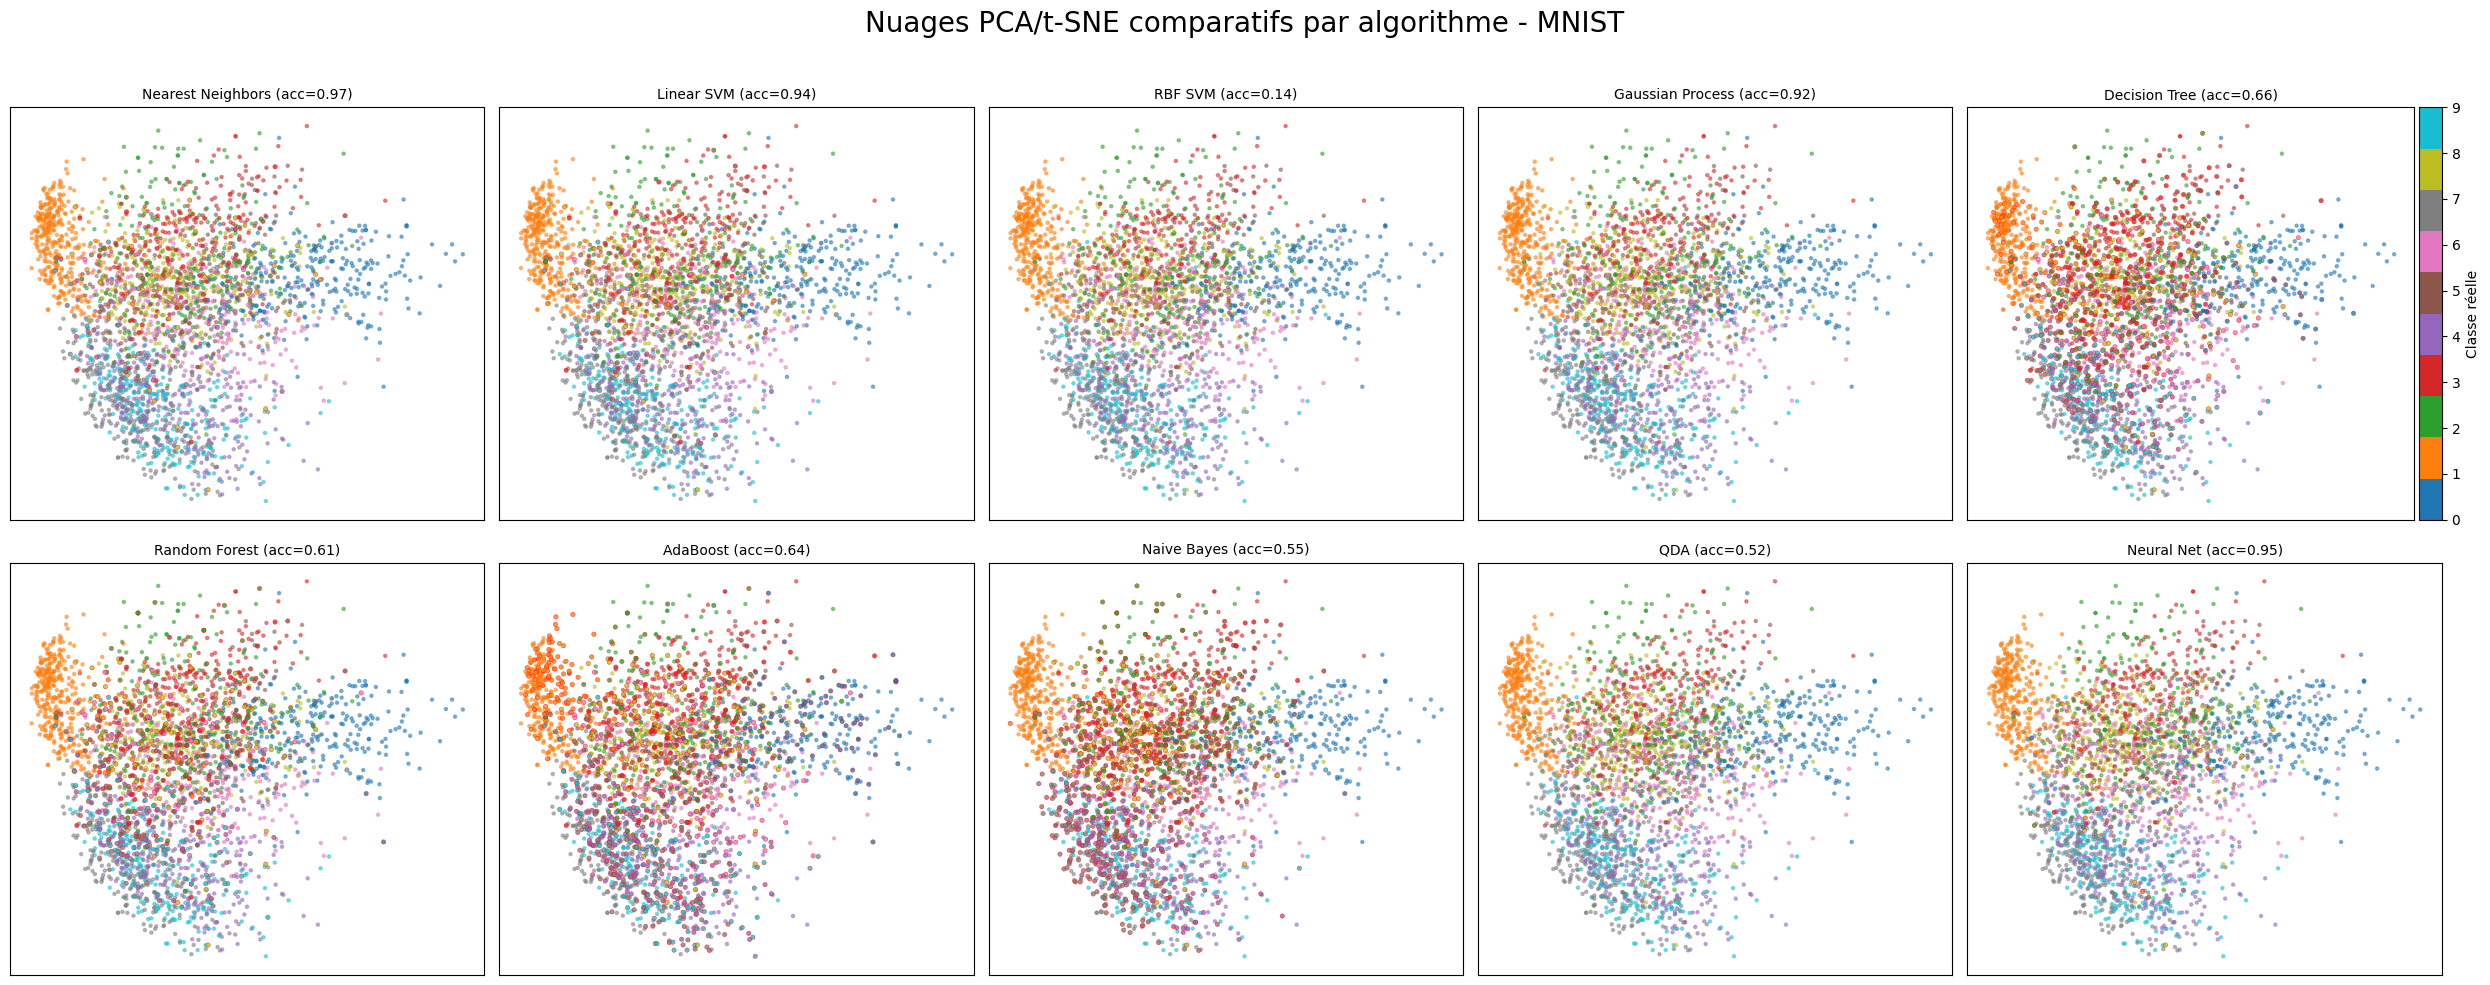

In [ ]:
dataset_cible = "MNIST"

# Charger tes X et y correspondants ici
if dataset_cible == "MNIST":
    X = X_mnist_normalized
    y = y_mnist
    # Réduction pour accélérer le rendu :
    from sklearn.utils import resample
    X, y = resample(X, y, n_samples=3000, random_state=42)
elif dataset_cible == "PlantVillage":
    X = X_plant_norm
    y = y_plant
    X, y = resample(X, y, n_samples=2000, random_state=42)
elif dataset_cible == "IRIS":
    X = X_iris_normalized
    y = y_iris


names = [
    "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
    "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes",
    "QDA", "Neural Net"
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000)
]


resultats_cible = resultats[resultats["Dataset"].str.contains(dataset_cible, case=False)]


use_tsne = False
if use_tsne:
    reducer = TSNE(n_components=2, random_state=42, perplexity=30)
else:
    reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X)


n_algos = len(classifiers)
cols = 5
rows = n_algos // cols + (n_algos % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

for idx, (name, clf) in enumerate(zip(names, classifiers)):
    ax = axes.flat[idx]
    try:
        clf.fit(X, y)
        y_pred = clf.predict(X)
    except Exception as e:
        print(f"{name} échoué: {e}")
        y_pred = np.zeros_like(y)


    try:
        acc = resultats_cible.loc[resultats_cible["Algorithme"].str.contains(name, case=False), "Accuracy"].values[0]
    except IndexError:
        acc = np.nan

    correct = y_pred == y
    incorrect = ~correct

    scatter = ax.scatter(
        X_reduced[correct, 0],
        X_reduced[correct, 1],
        c=y[correct],
        cmap='tab10',
        s=5,
        alpha=0.5
    )
    ax.scatter(
        X_reduced[incorrect, 0],
        X_reduced[incorrect, 1],
        c=y[incorrect],
        cmap='tab10',
        s=10,
        edgecolor='red',
        linewidth=0.3,
        alpha=0.8
    )

    ax.set_title(f"{name} (acc={acc:.2f})", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flat[j])


norm = mcolors.Normalize(vmin=y.min(), vmax=y.max())
cmap = cm.get_cmap("tab10")
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig.subplots_adjust(right=0.9)
divider = make_axes_locatable(axes[0, -1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(sm, cax=cax, label="Classe réelle")

plt.suptitle(f"Nuages PCA/t-SNE comparatifs par algorithme - {dataset_cible}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Visualisation par nuage de données- Iris**

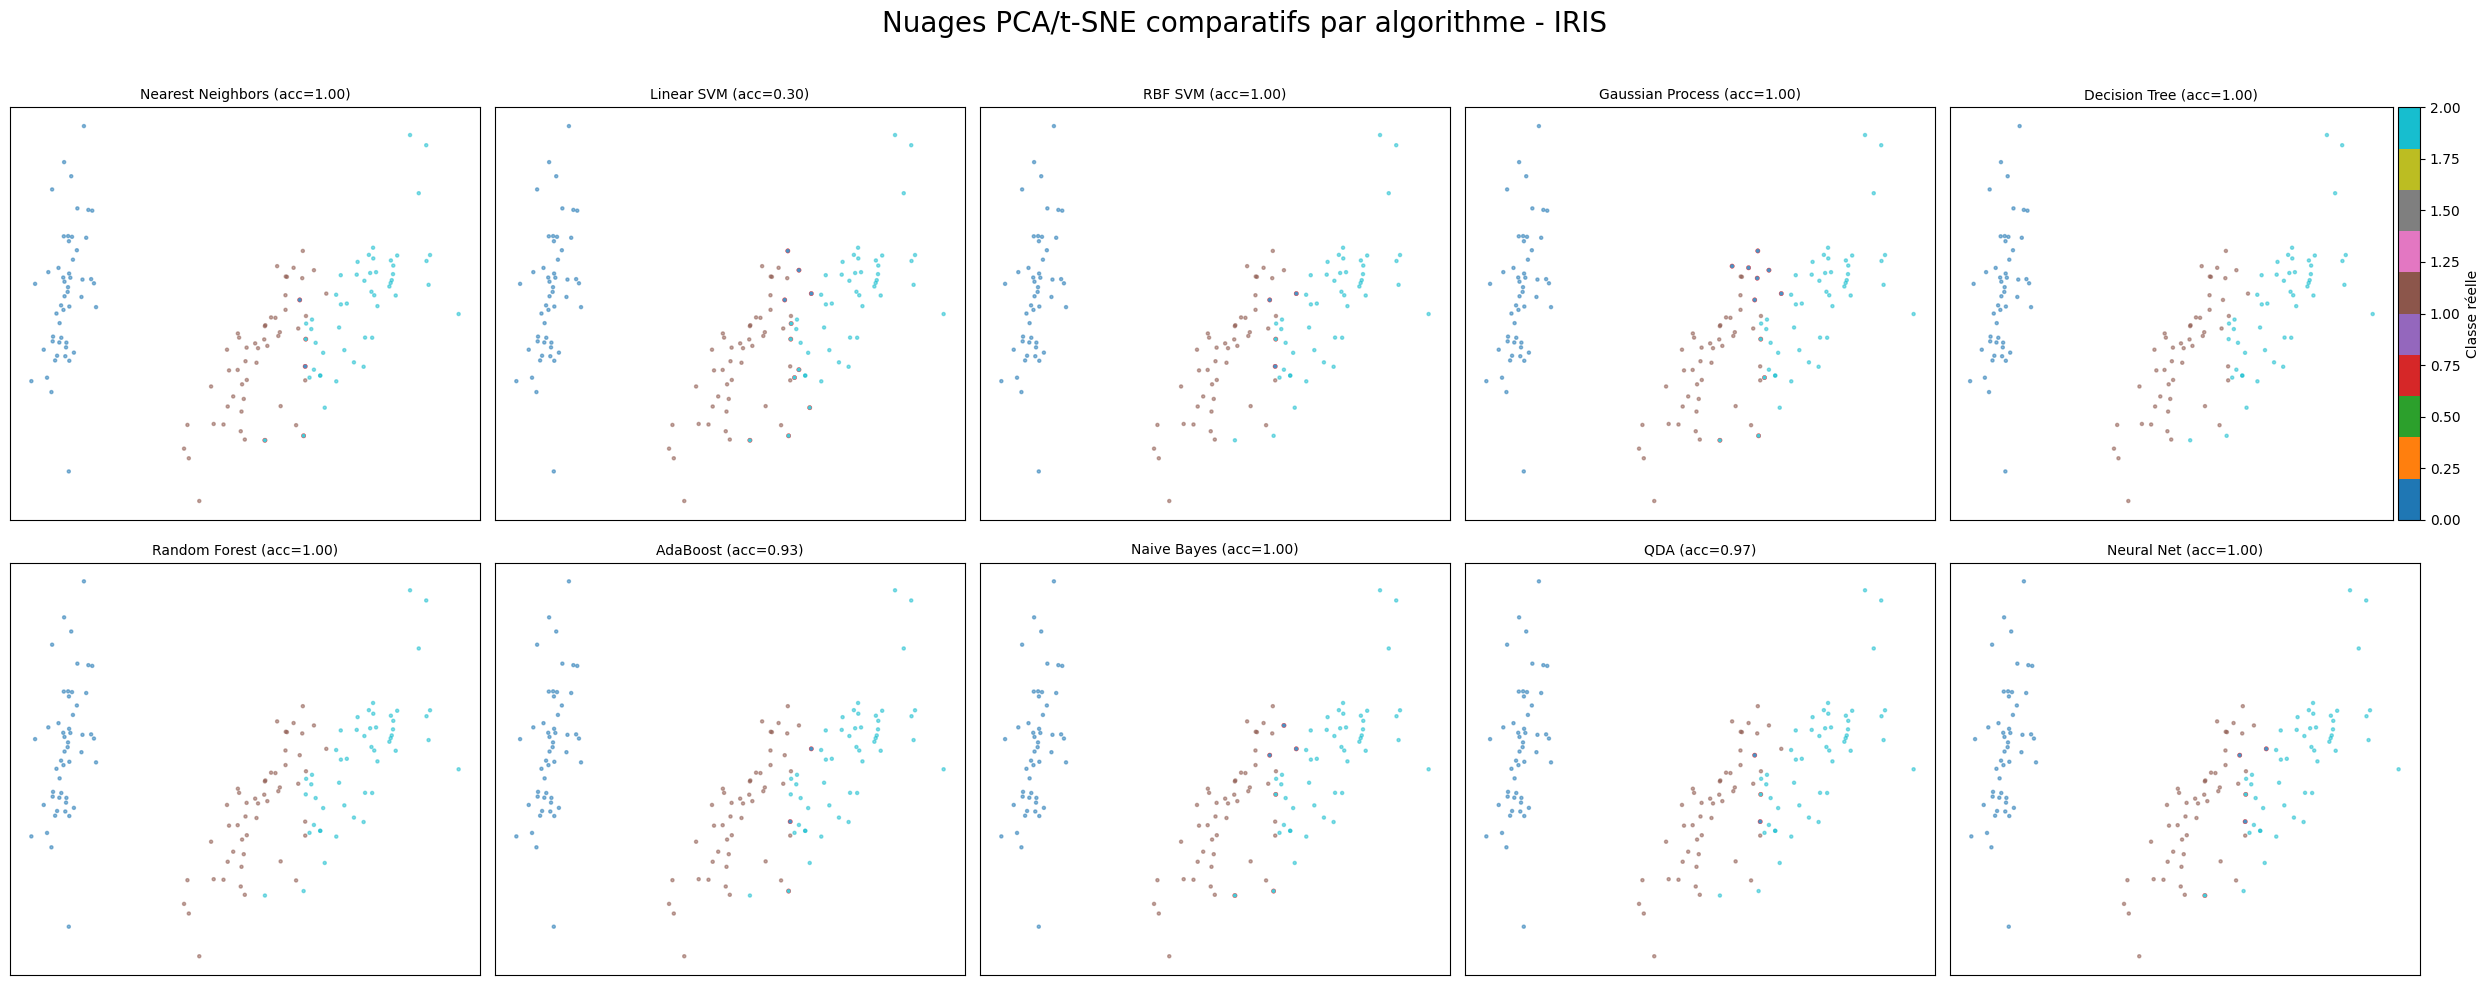

In [ ]:
dataset_cible = "IRIS"


if dataset_cible == "MNIST":
    X = X_mnist_normalized
    y = y_mnist
    # Réduction pour accélérer le rendu :
    from sklearn.utils import resample
    X, y = resample(X, y, n_samples=3000, random_state=42)
elif dataset_cible == "PlantVillage":
    X = X_plant_norm
    y = y_plant
    X, y = resample(X, y, n_samples=2000, random_state=42)
elif dataset_cible == "IRIS":
    X = X_iris_normalized
    y = y_iris


names = [
    "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
    "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes",
    "QDA", "Neural Net"
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000)
]


resultats_cible = resultats[resultats["Dataset"].str.contains(dataset_cible, case=False)]


use_tsne = False
if use_tsne:
    reducer = TSNE(n_components=2, random_state=42, perplexity=30)
else:
    reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X)


n_algos = len(classifiers)
cols = 5
rows = n_algos // cols + (n_algos % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

for idx, (name, clf) in enumerate(zip(names, classifiers)):
    ax = axes.flat[idx]
    try:
        clf.fit(X, y)
        y_pred = clf.predict(X)
    except Exception as e:
        print(f"{name} échoué: {e}")
        y_pred = np.zeros_like(y)


    try:
        acc = resultats_cible.loc[resultats_cible["Algorithme"].str.contains(name, case=False), "Accuracy"].values[0]
    except IndexError:
        acc = np.nan

    correct = y_pred == y
    incorrect = ~correct

    scatter = ax.scatter(
        X_reduced[correct, 0],
        X_reduced[correct, 1],
        c=y[correct],
        cmap='tab10',
        s=5,
        alpha=0.5
    )
    ax.scatter(
        X_reduced[incorrect, 0],
        X_reduced[incorrect, 1],
        c=y[incorrect],
        cmap='tab10',
        s=10,
        edgecolor='red',
        linewidth=0.3,
        alpha=0.8
    )

    ax.set_title(f"{name} (acc={acc:.2f})", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flat[j])


norm = mcolors.Normalize(vmin=y.min(), vmax=y.max())
cmap = cm.get_cmap("tab10")
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig.subplots_adjust(right=0.9)
divider = make_axes_locatable(axes[0, -1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(sm, cax=cax, label="Classe réelle")

plt.suptitle(f"Nuages PCA/t-SNE comparatifs par algorithme - {dataset_cible}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Analyse des résultats

**PlantVillage**

Pour commencer l'analyse des résultats, j'ai choisi de prendre mon jeu de données choisi qui est PlantVillage. Avant d'attaquer les résultats, il est important de se rappeler que ce jeu de données est basé sur des images couleurs de feuilles de différentes espèces avec divers cas de maladies. Il est bon de garder en tête cette information puisque les résultats obtenus avec les algorithmes testés dans ce projet ne sont pas nécessairement adaptés pour ce jeu de données, mais ce détail sera davantage élaboré après l'analyse des résultats.

Suite aux résultats, on peut observer que l'algorithme avec les meilleures performances pour ce jeu de données est le Neural Net. Les résultats visualisés, à partir du tableau et des graphiques, démontrent que les métriques (accuracy, precision, recall et F1-Score) tournent autour de 81%. Ce qui nous permet de dire que le modèle capture mieux les motifs complexes. De plus, le nuage de données démontre qu'une grande partie des données est bien groupée (couleur semblable ensemble) et donc que le modèle a bien classé les données avec quelques erreurs. Les erreurs sont entourées en rouge et on peut observer qu'un algorithme tel que Naive Bayes est couvert de rouge dû au fait qu'il y a beaucoup d'erreurs.

L'algorithme qui arrive en deuxième est le Linear SVM qui obtient des métriques autour de 75%. Les résultats plus bas que le Neural Net, mais aussi on peut relever que cet algorithme prend beaucoup plus de mémoire (4473.120 MB vs 3938.770 MB) et est beaucoup plus lent (469.014 secs vs 49.759 sec). Ce qui est considérable dans notre choix d'algorithme.

Pour ce qui est des autres algorithmes, on peut observer que les résultats sont peu élevés ce qui nous fait comprend que les algorithmes traditionnels ne sont pas le meilleur choix pour ce jeu de données. Dans ces cas-ci, la matrice de confusion est pertinente à prendre en compte. Si on compare avec la matrice de Neural Net, on peut observer une belle diagonale qui nous permet de comprendre que la plupart des données à bien été classé avec quelques exceptions. Alors que dans d'autres cas comme le Gaussian Process (dont on a dû réduire l'échantillon) a de la difficulté à classer les résultats avec un échantillon réduit et donc les classes tous dans la même classe. Toutefois, on peut justifier le fait de réduire l'échantillon avec notre métrique de mémoire qui démontre que pour lui et RBF SVM la mémoire utiliser pour 1 à 5% du jeu de données est équivalent et même plus élevé que pour d'autres algorithmes qui prendre le jeu de données complet.

Finalement, revenons au sujet des algorithmes classiques vs réseau neuronal. Bien que les algorithmes classiques peuvent donner une comparaison, elle reste très limiter en ce qui est relié aux images hautes dimensions. C'est la raison pour laquelle l'algorithme Neural Net est le plus efficace, car c'est ce qui reste le plus proche du réseau neuronal. Toutefois, il perd la structure spatiale de l'image. Il a aussi de la difficulté à détecter les formes, motifs et structures ce qui le rend plus intéressant pour des jeux de données tabulaires. C'est suite à cette conclusion que j'ai effectué mes recherches. J'ai trouvé qu'un algorithme tel que CNN aurait été plus pertinent pour mon jeu de données. Pour ce projet, je m'arrêterais à cette conclusion, mais dans une idée de pousser le projet, il pourrait être intéressant de tester cet algorithme.

**MNIST**

Nous passerons maintenant aux résultats pour le jeu de données pour MNIST. Contrairement au jeu de données précédent, cette fois-ci plusieurs algorithmes ont bien performé, mais celui qui s'est le mieux démarqué est le Nearest Neighbors avec 97% pour les métriques (accuracy, precision, recall, F1-Score). De plus, bien qu'il prend un peu plus de mémoire, il est plus rapide (47sec) que Linear SVM et Neural Net qui ont aussi bien performé avec des métriques dans les 94-95%.

De plus, on peut aussi observer que sa matrice de confusion est bien répartie. Comme je le mentionnais plus haut, les données sont bien réparties dans une diagonale et on peut observer qu'il y a quelques erreurs comme le chiffre 8 qui s'est fait classer dans la classe 3 à 21 reprises.

Le nuage de données démontre aussi que le modèle a bien réparti les données par groupe. On le voit même mieux que dans le jeu de données précédent. On peut bien observer les différents groupes de couleurs différentes qui nous permettent de déterminer que le modèle comprend bien la complexité et a généralisé.

On peut expliquer que cet algorithme est pertinent et performe bien pour ce jeu, car il compare directement les images par leur distance pixel par pixel. Dans le cas d'un ensemble d'images simple comme MNIST, l'algorithme est performant tant que le nombre de classes est modéré et que les données sont peu bruitées.

Dans le cas des autres algorithmes qui ont moins bien performé tel que QDA, Naives Bayes, Adaboost, Decision tree et RBF SVM, une des raisons principales est la haute dimension des images. En effet, cela revient à l'explication pour le jeu de données précédentes.  Les distances perdent leur signification et les patterns sont plus difficiles à trouver.

Finalement, comme le jeu de données précédent un algorithme tel que CNN pourrait être intéressante a essayé. Dans certains cas, on a pu observer une précision allant jusqu'à 99% pour le jeu de données MNIST. Encore une fois, ceci serait pour un futur projet.


**IRIS**

Terminons l'analyse par le jeu de données IRIS. La particularité d'IRIS est que la majorité des algorithmes ont très bien performé. Ceci s'explique par le fait que le jeu de données est petit avec seulement 3 classes bien séparer, peu ou pas de bruits importants.

Prenons plus tôt celui qui a le moins bien performé. Linear SVM a eu 30% d'accuracy et 13% de F1-score, car il a une mauvaise configuration des paramètres. Iris n'est pas parfaitement linéaire et donc sans ajustement l'algorithme peut échouer.

Maintenant pour déterminer quel algorithme est le meilleur. Puisque tous les résultats des algorithmes sont semblables. On peut se baser sur l'algorithme en lui-même. Nearest Neighbors et Decision tree sont simple à comprendre, facile à implémenter et très rapide. Neural Net et RBF SVM sont bien, mais complexe et nécessite beaucoup de ressources pour un si petit jeu de données.